# Introduction

Endothelial cells only.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import phenograph
from sklearn.neighbors import NearestNeighbors
import scipy
from metacells.core import Metacells
from sklearn.metrics import silhouette_score

from copy import deepcopy
import random

import os
import sys
sys.path.append("/Users/sharmar1/Desktop/python_funs/")
import utils

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE as TSNE

In [3]:
outbase = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/'

In [4]:
cols = utils.get_color_pal(100)

In [5]:
from matplotlib.cm import get_cmap
cols_use = get_cmap('tab20').colors

# Load full data

In [ ]:
adata_clean_combined = sc.read_h5ad('/Users/rs3380/Dropbox/lung_tumor/new_folders/output/exp2/clean_combined.h5ad')

In [ ]:
adata_clean_combined

In [ ]:
fig = plt.figure(figsize = (8*1, 8*1))
ax = fig.add_subplot(1, 1, 1)
cell_type = adata_clean_combined.obs['Celltype']
for j, item in enumerate(np.unique(cell_type)):
    ax.scatter(adata_clean_combined.obsm['X_tsne'][cell_type == item, 0], 
               adata_clean_combined.obsm['X_tsne'][cell_type == item, 1], 
               s = 1, color = cols_use[j], label = item)
ax.legend(markerscale = 7, fontsize = 14, ncol = 1, bbox_to_anchor=(0, 0, 1.5, 1.08), loc="right")
ax.axis('off');
#ax.set_title('Old clusters')

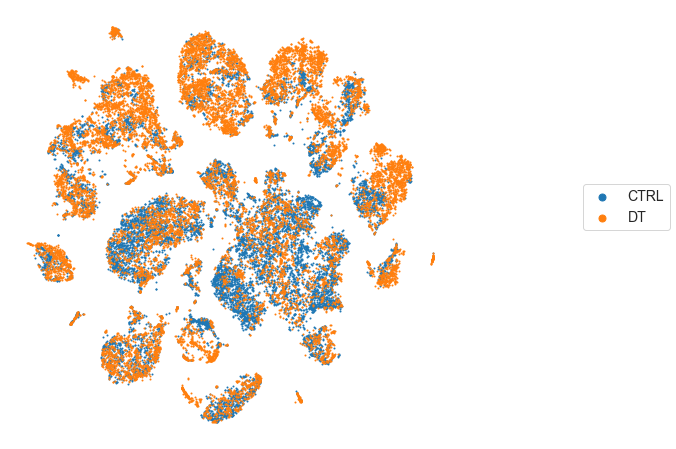

In [10]:
fig = plt.figure(figsize = (8*1, 8*1))
ax = fig.add_subplot(1, 1, 1)
cell_type = adata_clean_combined.obs['condition']
for j, item in enumerate(np.unique(cell_type)):
    ax.scatter(adata_clean_combined.obsm['X_tsne'][cell_type == item, 0], 
               adata_clean_combined.obsm['X_tsne'][cell_type == item, 1], 
               s = 1, color = cols[j], label = item)
ax.legend(markerscale = 7, fontsize = 14, ncol = 1, bbox_to_anchor=(0, 0, 1.5, 1.08), loc="right")
ax.axis('off');
#ax.set_title('Old clusters')

# Cleanup Endothelials

In [67]:
ENDOSELECT = np.isin(adata_clean_combined.obs['Celltype'], ['Lymphatic Endothelial', 'Blood Endothelial'])
#EINDICES = filtered_assn.loc[filtered_assn.isin(['Lymphatic Endothelial', 'Blood Endothelial'])].index
GSELECT = (adata_clean_combined.X[ENDOSELECT,:] > 0).sum(axis=0) > 10

In [68]:
adata_endo = adata_clean_combined[ENDOSELECT, GSELECT]

In [69]:
endo_cluster_saved = pd.read_csv('/Users/rs3380/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_full_leiden_50PCs_k30_res1.csv',
                           index_col=0, header=None, squeeze=True, names=['cluster'])

In [70]:
adata_endo

View of AnnData object with n_obs × n_vars = 3333 × 12131
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize'
    obsm: 'X_pca', 'X_tsne'
    layers: 'norm_count', 'norm_log'

In [71]:
adata_endo.obs['Endo_prelim_clusters'] = endo_cluster_saved.loc[[int(j) for j in adata_endo.obs.index]].values

Trying to set attribute `.obs` of view, copying.


Text(0, 0.5, 'Frequency')

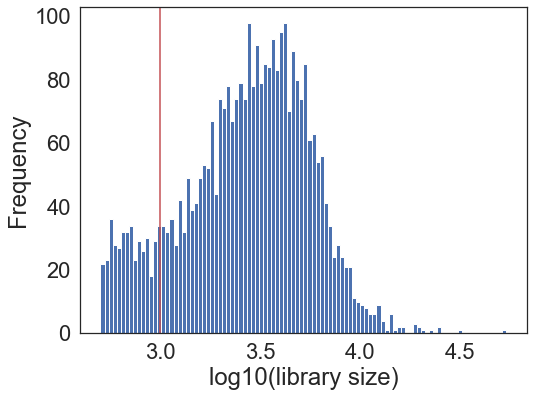

In [72]:
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.hist(np.log10(adata_endo.obs['libsize']), 100);
ax.axvline(3, c = 'r')
ax.set_xlabel('log10(library size)')
ax.set_ylabel('Frequency')

In [73]:
FSELECT = (adata_endo.obs['libsize'] < 1000) | adata_endo.obs['Endo_prelim_clusters'].isin([6,7])

In [75]:
adata_clean_endo = adata_endo[~FSELECT, :]

In [76]:
adata_clean_endo

View of AnnData object with n_obs × n_vars = 2815 × 12131
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Endo_prelim_clusters'
    obsm: 'X_pca', 'X_tsne'
    layers: 'norm_count', 'norm_log'

## Load old clusters

In [86]:
endo_cluster = pd.read_csv('/Users/rs3380/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_filtered_leiden_50PCs_k30_res1.csv', 
                                     index_col=0, squeeze=True, names=['cluster'])

In [87]:
adata_clean_endo.obs['Clusters_endo'] = endo_cluster.loc[[int(j) for j in adata_clean_endo.obs.index]].values

Trying to set attribute `.obs` of view, copying.


## PCA, tSNE, Clusters

In [88]:
pca_endo = PCA(n_components=1000, svd_solver='randomized')
filtered_endo_pcaproj = pd.DataFrame(pca_endo.fit_transform(adata_clean_endo.layers['norm_log']),
                                    index=adata_clean_endo.obs.index)

In [ ]:
tsne_res = pd.read_csv('/Users/rs3380/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_clean_tsneproj_50PCs_p100.csv', 
                  index_col = 0)

In [90]:
adata_clean_endo.obsm['X_pca'] = filtered_endo_pcaproj.values[:, 0:50]
adata_clean_endo.obsm['X_tsne'] = tsne_res.values

## Endothelial cell type annotation

In [9]:
ENDOMARKERS = ['PECAM1','CDH5', # canonical EC
               'TMEM100','FOXF1', # lung specific 
               'MGP','PLAT','GJA4','GJA5','EDN1','FBLN2','HEY1', # artery
                'VWF','VCAM1','SLC6A2','CD200','BST1','BST2','CH25H', # large vessel, vein
               'GPIHBP1','SEMA3C','CADM1','HILPDA', # capillary 2
               'CAR4','FIBIN','CYP4B1','EDNRB','KDR', # capillary 1
               'LYVE1','PROX1','THY1','MMRN1','CP','FGL2', # lymphatic
              ]

In [11]:
len(ENDOMARKERS)

33

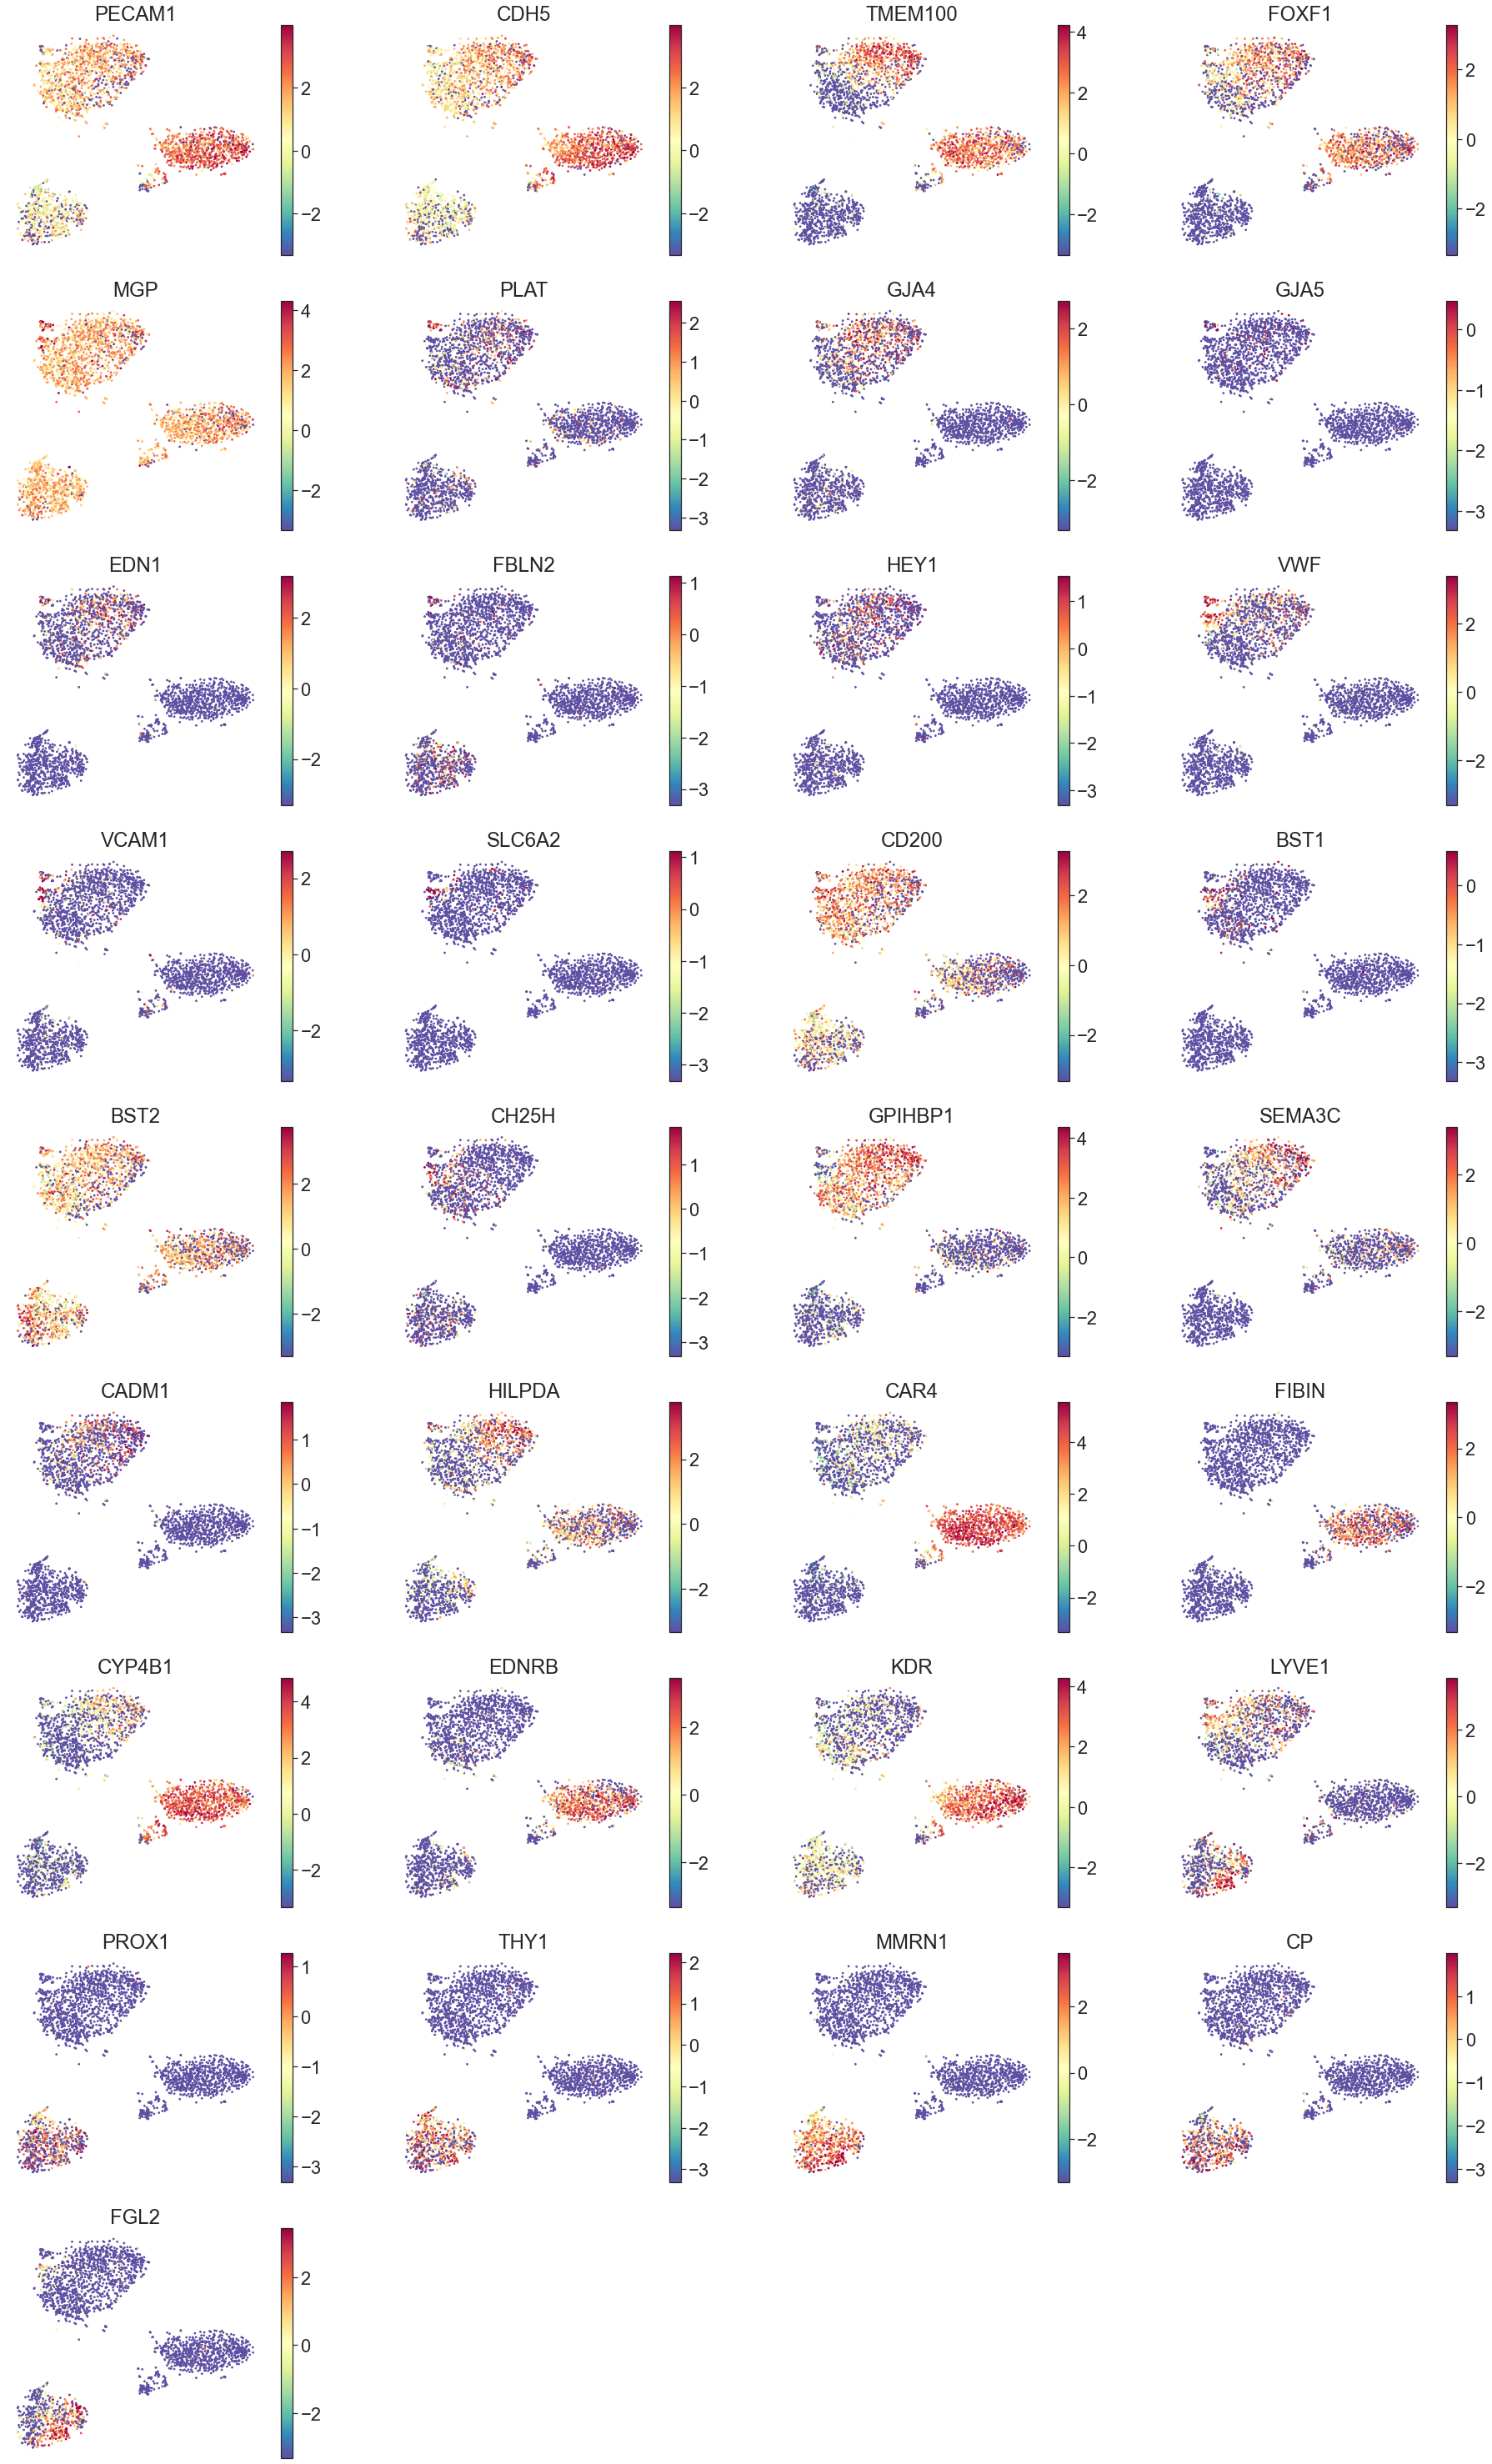

In [95]:
fig = plt.figure(figsize = (8*4, 6*13))
for j, item in enumerate(ENDOMARKERS):
    ax = fig.add_subplot(13, 4, j + 1)
    c = adata_clean_endo.layers['norm_log'][:, adata_clean_endo.var_names.get_loc(item)]
    im1 = ax.scatter(adata_clean_endo.obsm['X_tsne'][:, 0], 
                     adata_clean_endo.obsm['X_tsne'][:, 1], s = 3,
                     c = c, vmin = np.percentile(c, 1), vmax = np.percentile(c, 99), 
                     cmap = 'Spectral_r')
    ax.axis('off')
    ax.set_title(item)
    fig.colorbar(im1)

In [14]:
ENDOMARKERS_dict = {'canonical_EC': ['PECAM1','CDH5'],
                    'lung_specific': ['TMEM100','FOXF1'],
                    'artery': ['MGP','PLAT','GJA4','GJA5','EDN1','FBLN2','HEY1'], # artery
                    'large vessel/vein': ['VWF','VCAM1','SLC6A2','CD200','BST1','BST2','CH25H'], # large vessel, vein
                    'capillary 2': ['GPIHBP1','SEMA3C','CADM1','HILPDA'], # capillary 2
                    'capillary 1': ['CAR4','FIBIN','CYP4B1','EDNRB','KDR'], # capillary 1
                    'lymphatic': ['LYVE1','PROX1','THY1','MMRN1','CP','FGL2'] # lymphatic
                   }

col_markers = []
ct = 0
for item, values in ENDOMARKERS_dict.items():
    col_markers = col_markers + [cols_use[ct]]*len(values)
    ct = ct + 1

In [97]:
endo_genes_undict = [j for k in ENDOMARKERS_dict.values() for j in k]
endo_genes = [adata_clean_endo.var_names.get_loc(j) for j in endo_genes_undict]
endo_sub_data = pd.DataFrame(adata_clean_endo.layers['norm_log'][:, endo_genes].copy(), 
                             columns = endo_genes_undict)
endo_sub_data['Cluster'] = adata_clean_endo.obs['Clusters_endo'].values

In [98]:
endo_sub_data_avg = endo_sub_data.groupby('Cluster').mean()

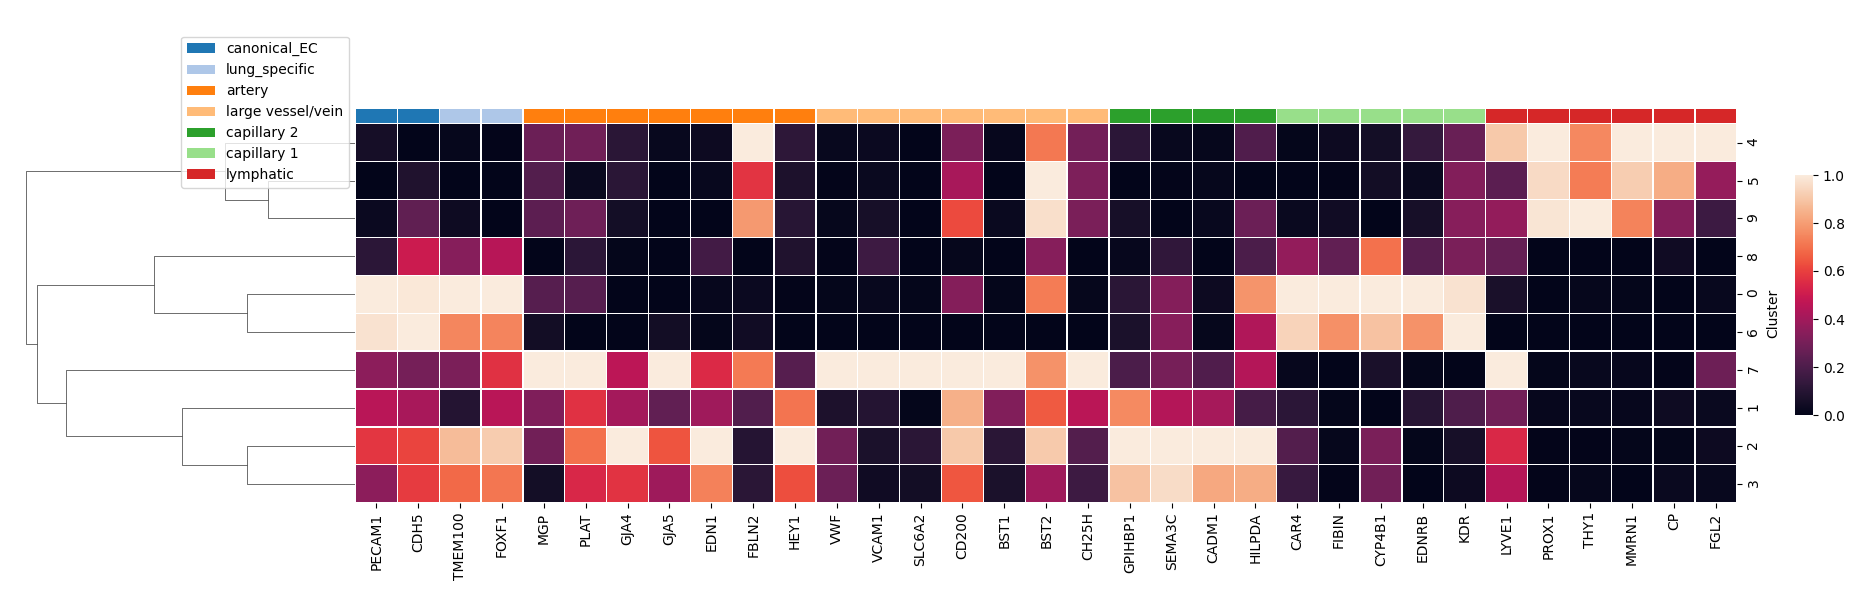

In [99]:
import matplotlib as mpl
mpl.style.use('default')

g = sns.clustermap(endo_sub_data_avg, standard_scale = 1, col_colors = col_markers, 
                   col_cluster = False, figsize = (18, 6), linewidth = 0.2, 
                   cbar_pos=(1, .3, .01, .4))

# Draw the legend bar for the classes                 
for ct, label in enumerate([j for j in ENDOMARKERS_dict.keys()]):
    g.ax_col_dendrogram.bar(0, 0, color=cols_use[ct],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor = (0, 0.8))


In [100]:
res = utils.run_diffusion_maps(pd.DataFrame(adata_clean_endo.obsm['X_pca']), knn = 30)

Determing nearest neighbor graph using euclidean distance metric


In [101]:
def impute_expression(T,expression,TSTEPS=4):
    T_step = T
    # impute values first, then keep stepping to speed it up
    T_imputed = T_step.dot(expression.values)
    for i in range(1,TSTEPS):
        print('step {}'.format(i+1))
        T_imputed = T_step.dot(T_imputed)
    expression_imputed = pd.DataFrame(T_imputed,index=expression.index, columns=expression.columns)
    return expression_imputed

In [102]:
filtered_endo_imputed = impute_expression(res['T'], pd.DataFrame(adata_clean_endo.layers['norm_log']), TSTEPS=4)

step 2
step 3
step 4


In [105]:
adata_clean_endo.obsm['imputed_data'] = filtered_endo_imputed.values

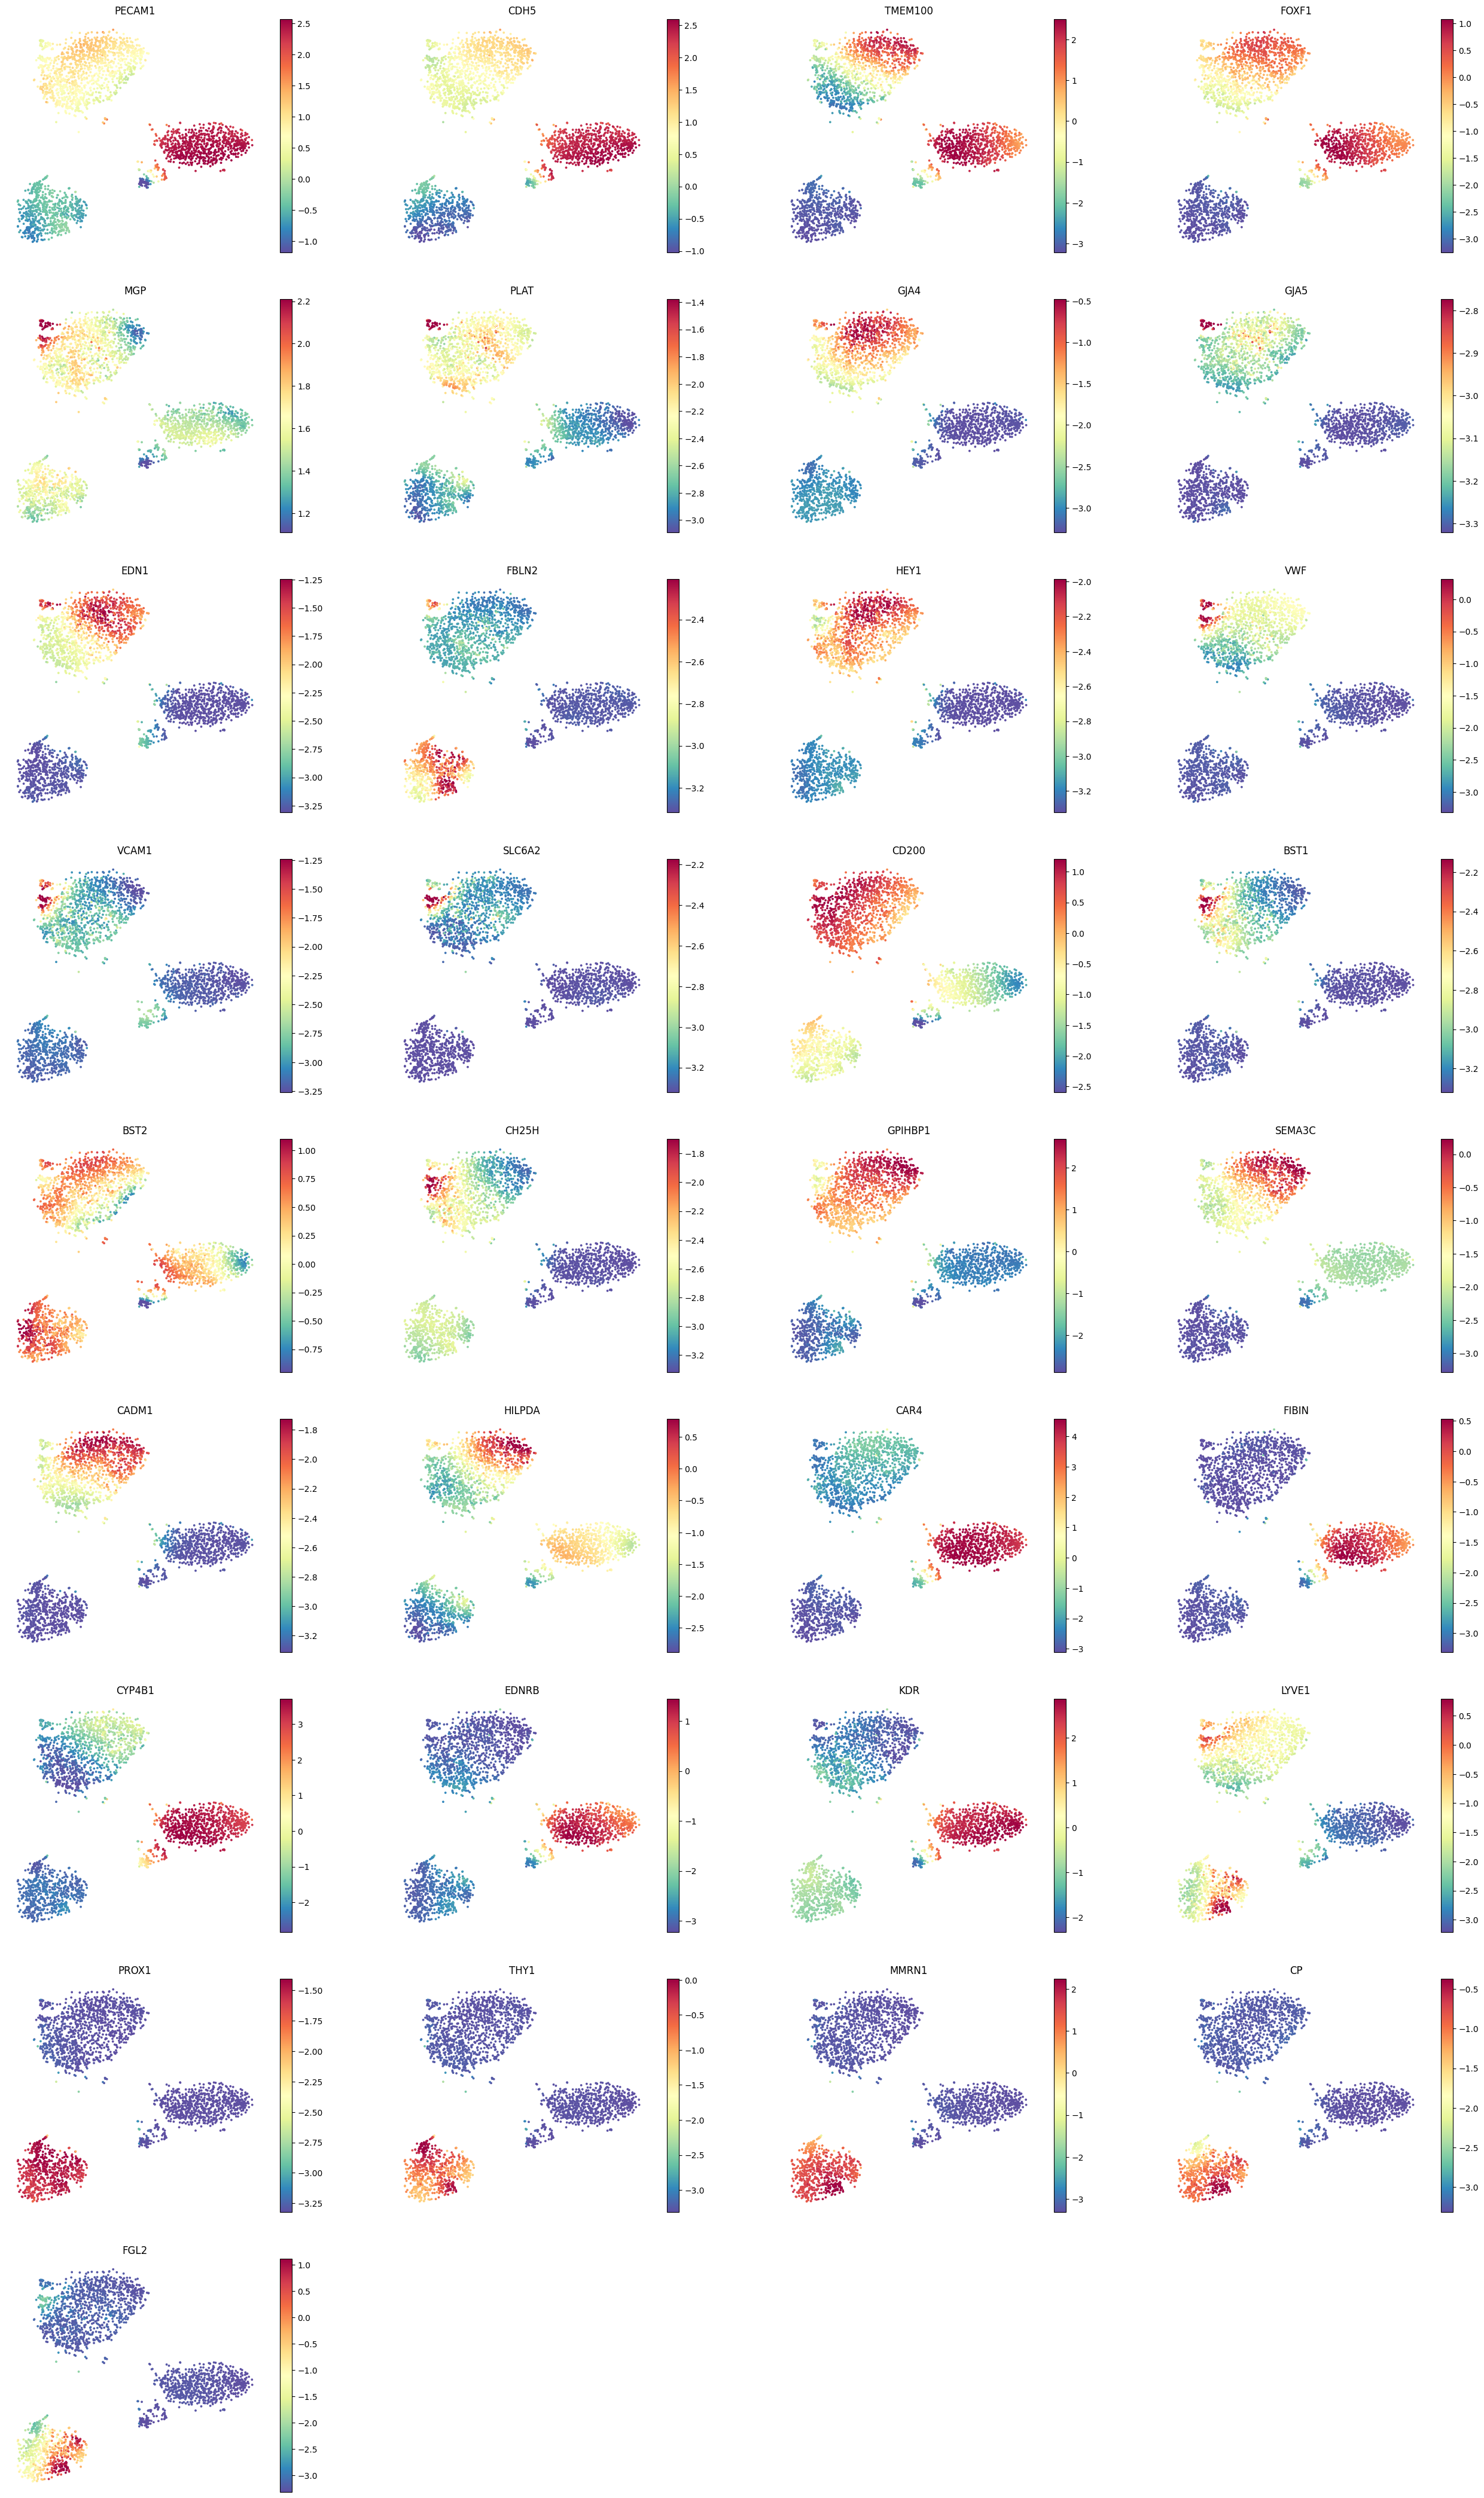

In [106]:
fig = plt.figure(figsize = (8*4, 6*13))
for j, item in enumerate(ENDOMARKERS):
    ax = fig.add_subplot(13, 4, j + 1)
    c = adata_clean_endo.obsm['imputed_data'][:, adata_clean_endo.var_names.get_loc(item)]
    im1 = ax.scatter(adata_clean_endo.obsm['X_tsne'][:, 0], 
                     adata_clean_endo.obsm['X_tsne'][:, 1], s = 3,
                     c = c, vmin = np.percentile(c, 1), vmax = np.percentile(c, 99), 
                     cmap = 'Spectral_r')
    ax.axis('off')
    ax.set_title(item)
    fig.colorbar(im1)

In [15]:
endo_genes_undict = [j for k in ENDOMARKERS_dict.values() for j in k]
endo_genes = [adata_clean_endo.var_names.get_loc(j) for j in endo_genes_undict]
endo_sub_data = pd.DataFrame(adata_clean_endo.obsm['imputed_data'][:, endo_genes].copy(), 
                             columns = endo_genes_undict)
endo_sub_data['Cluster'] = adata_clean_endo.obs['Clusters_endo'].values

In [16]:
endo_sub_data_avg = endo_sub_data.groupby('Cluster').mean()

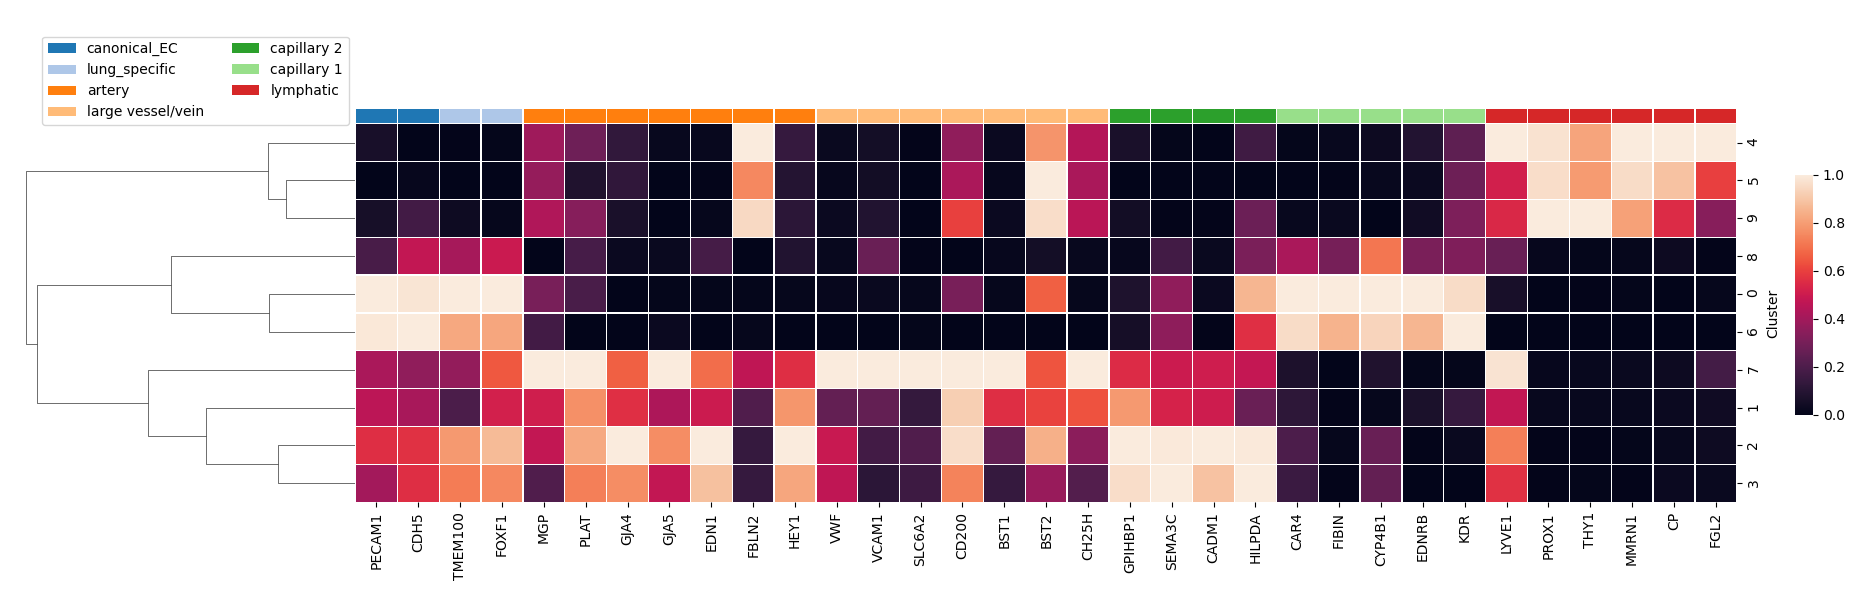

In [18]:
%matplotlib inline
import matplotlib as mpl
mpl.style.use('default')

g = sns.clustermap(endo_sub_data_avg, standard_scale = 1, col_colors = col_markers, 
                   col_cluster = False, figsize = (18, 6), linewidth = 0.2, 
                   cbar_pos=(1, .3, .01, .4))

# Draw the legend bar for the classes                 
for ct, label in enumerate([j for j in ENDOMARKERS_dict.keys()]):
    g.ax_col_dendrogram.bar(0, 0, color=cols_use[ct],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(ncol=2, bbox_to_anchor = (0, 0.8))

In [29]:
# save for source data.
endo_sub_data_avg_T = endo_sub_data_avg.T
endo_sub_data_avg_T['celltype_color'] = col_markers
endo_sub_data_avg_T.to_csv('/Users/sharmar1/Dropbox/lung_tumor/new_folders/source_data/Fig_S3A_upper_panel.csv')

In [110]:
endo_coarse_assn = {'artery_vein':[7],
                   'capillary_2':[1,2,3],
                   'capillary_1':[0,6],
                   'inflammatory_capillary':[8],
                   'lymphatic_endothelial':[4,5,9]
                  }

# individual cell assignments
endo_coarse_assn_clustmap = {}
for a,clusts in endo_coarse_assn.items():
    for c in clusts:
        endo_coarse_assn_clustmap[c] = a

endo_coarse = pd.Series(adata_clean_endo.obs['Clusters_endo'].map(endo_coarse_assn_clustmap),
                        name='assignment')

In [111]:
adata_clean_endo.obs['Celltype_endo'] = endo_coarse

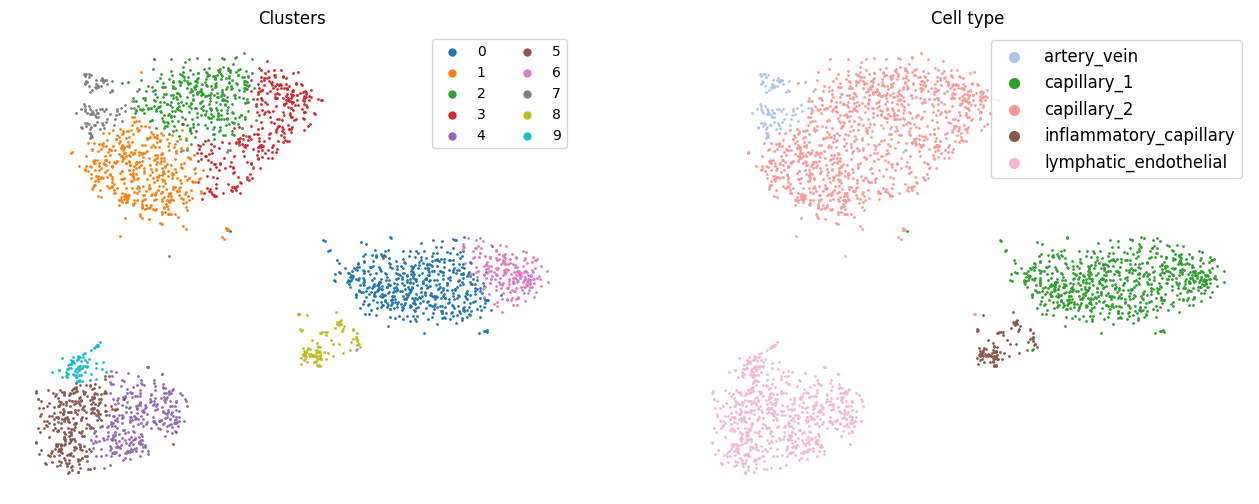

In [113]:
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
old_cluster = adata_clean_endo.obs['Clusters_endo']
for j in np.unique(old_cluster):
    ax.scatter(adata_clean_endo.obsm['X_tsne'][old_cluster == j, 0], 
               adata_clean_endo.obsm['X_tsne'][old_cluster == j, 1], 
               s = 1, c = cols[j], label = str(j))
ax.legend(markerscale = 5, fontsize = 10, ncol = 2)
ax.axis('off');
ax.set_title('Clusters')

ax = fig.add_subplot(1, 2, 2)
new_cluster = adata_clean_endo.obs['Celltype_endo']
for j, item in enumerate(np.unique(new_cluster)):
    ax.scatter(adata_clean_endo.obsm['X_tsne'][new_cluster == item, 0], 
               adata_clean_endo.obsm['X_tsne'][new_cluster == item, 1], 
               s = 1, color = cols_use[3*j + 1], label = item)
ax.legend(markerscale = 7, fontsize = 12, ncol = 1)
ax.axis('off');
ax.set_title('Cell type')
fig.savefig(outbase + 'Endothelial_celltype.png', dpi = 150, bbox_inches = 'tight')

## Additional visualizations

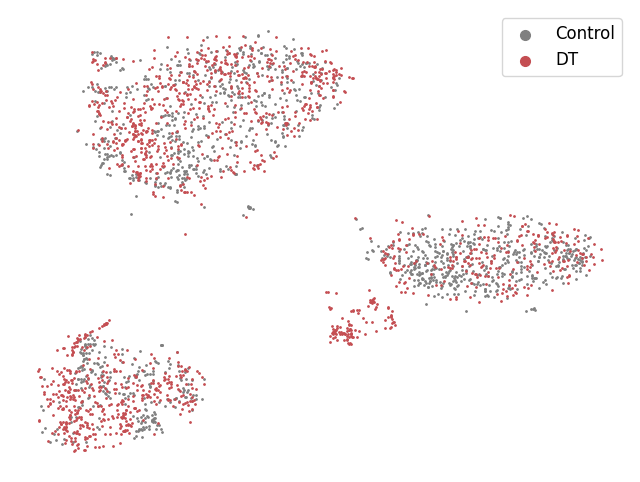

In [115]:
plt.figure(figsize = (8, 6))
plt.scatter(adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'CTRL', 0], 
            adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'CTRL', 1], s = 1, c = 'grey',
            label = 'Control')
plt.scatter(adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'DT', 0], 
            adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'DT', 1], s = 1, c = 'r', 
            label = 'DT')
plt.axis('off')
plt.legend(markerscale = 7, fontsize = 12)
plt.savefig(outbase + 'Ctrl_DT_endothelial.png', dpi = 150, bbox_inches = 'tight')

In [116]:
df_temp = pd.DataFrame({'tsne_x': adata_clean_endo.obsm['X_tsne'][:, 0], 
                        'tsne_y': adata_clean_endo.obsm['X_tsne'][:, 1], 
                        'condition': adata_clean_endo.obs['condition']}, index = adata_clean_endo.obs.index)

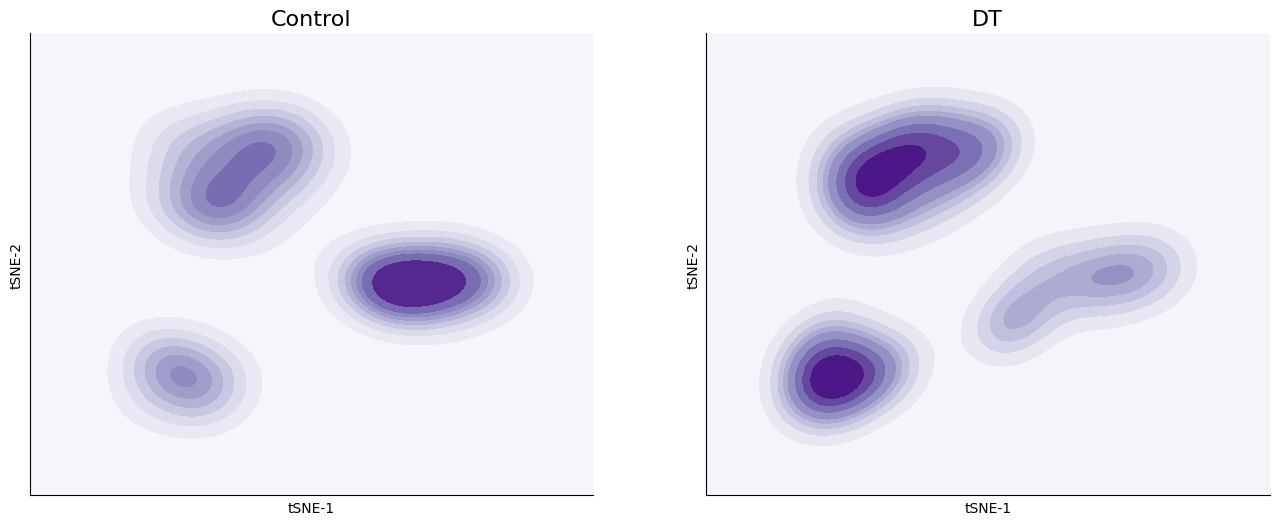

In [117]:
fig = plt.figure(figsize = (8*2, 6))
ax = fig.add_subplot(1, 2, 1)
sns.kdeplot(data=df_temp[df_temp['condition'] == 'CTRL'], x="tsne_x", y="tsne_y",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax)
ax.scatter(adata_clean_endo.obsm['X_tsne'][:, 0], adata_clean_endo.obsm['X_tsne'][:, 1], s = 0)
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('Control', fontsize = 16)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax = fig.add_subplot(1, 2, 2)
sns.kdeplot(data=df_temp[df_temp['condition'] == 'DT'], x="tsne_x", y="tsne_y",
    fill=True, thresh=0, levels=10, cmap="Purples", ax = ax)
ax.scatter(adata_clean_endo.obsm['X_tsne'][:, 0], adata_clean_endo.obsm['X_tsne'][:, 1], s = 0)
#ax.axis('off');
ax.set_xticks([]);
ax.set_yticks([]);
ax.set_title('DT', fontsize = 16)
ax.set_xlabel('tSNE-1')
ax.set_ylabel('tSNE-2')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig(outbase + 'Ctrl_DT_kdeplot_endothelial.png', dpi = 150, bbox_inches = 'tight')

In [119]:
#adata_clean_endo.write_h5ad(outbase + 'clean_endo.h5ad')

# New figures

In [10]:
outbase_new = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial_new_figures/'

In [7]:
adata_clean_endo = sc.read_h5ad('/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/clean_endo.h5ad')

In [19]:
np.unique(new_cluster)

array(['artery_vein', 'capillary_1', 'capillary_2',
       'inflammatory_capillary', 'lymphatic_endothelial'], dtype=object)

In [21]:
celltype_map = {'artery_vein': 'Artery vein', 'capillary_1': 'Capillary 1', 'capillary_2': 'Capillary 2', 
                'inflammatory_capillary': 'Inflammatory capillary', 'lymphatic_endothelial': 'LEC'}
new_ct = [celltype_map[j] for j in adata_clean_endo.obs['Celltype_endo']]
adata_clean_endo.obs['new_celltype'] = new_ct

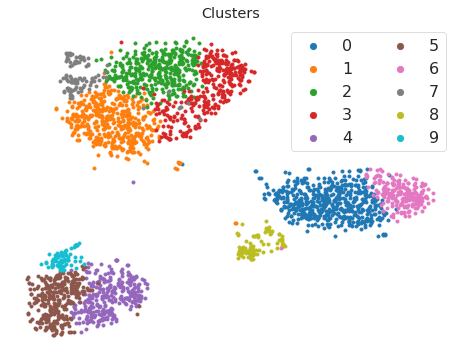

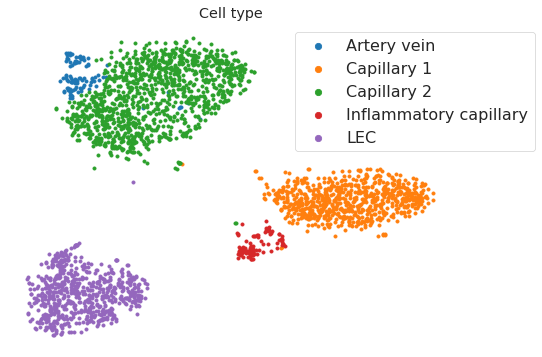

In [27]:
%matplotlib inline
fig = plt.figure(figsize = (8*1, 6*1))
ax = fig.add_subplot(1, 1, 1)
old_cluster = adata_clean_endo.obs['Clusters_endo']
for j in np.unique(old_cluster):
    ax.scatter(adata_clean_endo.obsm['X_tsne'][old_cluster == j, 0], 
               adata_clean_endo.obsm['X_tsne'][old_cluster == j, 1], 
               s = 10, c = cols[j], label = str(j))
ax.legend(markerscale = 2, fontsize = 16, ncol = 2)
ax.axis('off');
ax.set_title('Clusters')
fig.savefig(outbase_new + 'Endothelial_clusters.png', dpi = 150, bbox_inches = 'tight')

fig = plt.figure(figsize = (8*1, 6*1))
ax = fig.add_subplot(1, 1, 1)
new_cluster = adata_clean_endo.obs['new_celltype']
for j, item in enumerate(np.unique(new_cluster)):
    ax.scatter(adata_clean_endo.obsm['X_tsne'][new_cluster == item, 0], 
               adata_clean_endo.obsm['X_tsne'][new_cluster == item, 1], 
               s = 10, color = cols_use[2*j], label = item)
ax.legend(markerscale = 2, fontsize = 16, ncol = 1, bbox_to_anchor = [0, 0, 1.2, 1])
ax.axis('off');
ax.set_title('Cell type')
fig.savefig(outbase_new + 'Endothelial_celltype.png', dpi = 150, bbox_inches = 'tight')

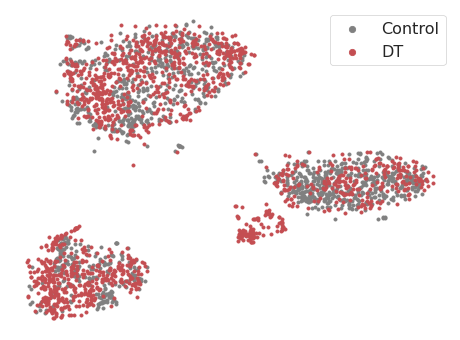

In [29]:
plt.figure(figsize = (8, 6))
plt.scatter(adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'CTRL', 0], 
            adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'CTRL', 1], s = 10, c = 'grey',
            label = 'Control')
plt.scatter(adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'DT', 0], 
            adata_clean_endo.obsm['X_tsne'][adata_clean_endo.obs['condition'] == 'DT', 1], s = 10, c = 'r', 
            label = 'DT')
plt.axis('off')
plt.legend(markerscale = 2, fontsize = 16)
plt.savefig(outbase_new + 'Ctrl_DT_endothelial.png', dpi = 150, bbox_inches = 'tight')

# Factor analysis

In [6]:
adata_endo = sc.read_h5ad('/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/clean_endo.h5ad')

In [13]:
gs_saved = pd.read_csv('/Users/sharmar1/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_schpf_20f_gene_scores.csv',
                              index_col=0)
cs_saved = pd.read_csv('/Users/sharmar1/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_schpf_20f_cell_scores.csv',
                              index_col=0)

gs_saved has factors on the columns, gene-name in the rows. each entry is the gene score associated with each factor and gene.

In [26]:
gs_saved.head()

0         1         2         3         4         5  \
0610007P14RIK  0.013893  0.444434  0.151513  0.007457  0.573555  0.012609   
0610009B22RIK  0.011117  0.484327  0.003230  0.304648  0.006678  0.008735   
0610009L18RIK  0.056464  0.020480  0.018404  0.031353  0.033923  1.948665   
0610009O20RIK  0.408969  0.464335  0.784847  0.545740  0.006813  0.407159   
0610010F05RIK  0.042323  0.015830  1.516604  0.493043  1.161012  0.035193   

                      6         7         8         9        10        11  \
0610007P14RIK  0.448073  0.120652  0.007597  0.017928  0.344951  0.350615   
0610009B22RIK  0.588740  0.120380  0.303754  0.178953  0.598575  0.004770   
0610009L18RIK  0.028532  1.945542  0.031845  0.061096  0.773793  0.026743   
0610009O20RIK  1.557770  0.005164  0.006080  0.013709  0.358230  0.355457   
0610010F05RIK  0.799824  0.020849  0.508533  0.049733  0.022909  0.487430   

                     12        13        14        15        16        17  \
0610007P14RIK  0.011161  0.013276  1.540477  0.010396  1.261889  1.204953   
0610009B22RIK  0.418007  0.011471  1.106747  0.008126  1.910268  0.903393   
0610009L18RIK  0.384344  0.052740  1.335221  0.041197  0.047240  0.042687   
0610009O20RIK  0.008611  0.011161  1.179769  0.008714  0.009574  0.009461   
0610010F05RIK  0.035633  0.043207  0.027998  0.641991  0.036049  0.032314   

                     18        19  
0610007P14RIK  0.431533  0.032377  
0610009B22RIK  0.003664  0.023911  
0610009L18RIK  0.018881  0.097931  
0610009O20RIK  0.831496  0.026412  
0610010F05RIK  0.940949  0.086317

cs_saved has factors on the columns, cell-id/cell-barcode in the rows. each entry is the cell score associated with each factor and cell.

In [27]:
cs_saved.head()

0         1         2         3         4  \
120703409145716001  0.328662  1.219104  0.000648  0.001137  1.225979   
120703409646299001  0.000366  1.188153  0.000656  0.110339  1.915256   
120703436052205001  0.001326  0.002674  3.169373  0.004110  0.001610   
120726943315830001  0.063475  0.000873  0.000803  0.001385  0.000537   
120772948875683001  0.000329  0.000615  2.349444  2.439973  0.002844   

                           5         6         7         8         9  \
120703409145716001  0.000833  0.000703  0.143387  0.000565  0.469394   
120703409646299001  0.000847  0.000693  0.295697  0.000575  0.204033   
120703436052205001  0.003162  0.002543  1.185881  0.002080  0.661650   
120726943315830001  0.001026  2.333438  0.111157  1.215745  0.238449   
120772948875683001  0.000739  0.371860  0.001234  0.000512  0.034093   

                          10        11        12        13        14  \
120703409145716001  2.171859  0.000644  0.000591  0.546712  0.000450   
120703409646299001  0.908927  0.000636  0.063477  0.032222  0.000472   
120703436052205001  0.064201  0.002408  0.002220  0.001589  1.183886   
120726943315830001  0.001219  1.262223  0.000701  0.098773  0.374945   
120772948875683001  0.010358  0.192679  0.000525  0.000424  1.290523   

                          15        16        17        18        19  
120703409145716001  0.128342  0.000391  0.613928  0.145423  0.000662  
120703409646299001  0.000660  0.820127  0.212678  1.015899  0.227701  
120703436052205001  0.700952  0.001476  0.001076  0.003060  0.002576  
120726943315830001  0.000790  0.755115  0.463456  0.053098  0.022085  
120772948875683001  0.099962  0.000355  0.073625  0.128753  0.000621

In [28]:
adata_endo

AnnData object with n_obs × n_vars = 2815 × 12131
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Endo_prelim_clusters', 'Clusters_endo', 'Celltype_endo'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

In [29]:
endo_celltype_cond = adata_endo.obs['Clusters_endo'].astype(str) + ' ' + adata_endo.obs['condition'].astype(str)

In [30]:
endo_celltype_cond.head()

120703409145716001    4 DT
120703409646299001    4 DT
120703436052205001    6 DT
120726943315830001    2 DT
120772948875683001    8 DT
dtype: object

In [31]:
cs_saved.set_index(cs_saved.index.astype(str), inplace=True)

In [32]:
endo_factor_mean = cs_saved.groupby(endo_celltype_cond).mean()

In [33]:
prop_factor = adata_endo.obs['condition']
group_factor = adata_endo.obs['Clusters_endo']

prop = (group_factor
        .groupby(prop_factor)
        .value_counts(normalize=True)
        .rename('prop')
        .reset_index())

In [34]:
prop_cluster_cond = pd.Series(prop['prop'].values, 
                              index=prop['Clusters_endo'].astype(str) + ' ' + prop['condition'].astype(str))

In [35]:
condition_cdict = {
    'CTRL': 'darkgrey',
    'DT': 'tab:red',
}

In [36]:
import matplotlib.cm as cm

In [37]:
greencolor_scale = [cm.Greens(x) for x in prop_cluster_cond]

In [38]:
col_colors = pd.DataFrame({
                'Condition': [condition_cdict[c] for c in prop['condition']],
                'sample_prop': [cm.Greens(x) for x in prop_cluster_cond]
                }, index=prop_cluster_cond.index)

In [39]:
ctype_map = {}
for j in np.unique(adata_endo.obs['Clusters_endo']):
    ctype_map[j] = np.unique(adata_endo.obs['Celltype_endo'][adata_endo.obs['Clusters_endo'] == j])[0]
    #print([j, np.unique(adata_myeloid.obs['Celltype_myeloid'][adata_myeloid.obs['Clusters_myeloid'] == j])])

In [40]:
cols = utils.get_color_pal(100)
color_val_ctype = {}
for j, item in enumerate(np.unique(adata_endo.obs['Celltype_endo'])):
    color_val_ctype[item] = cols[j]

In [41]:
col_ctype = []
for item in col_colors.index:
    col_ctype.append(color_val_ctype[ctype_map[int(item[0:item.find(' ')])]])
col_colors['Celltype'] = col_ctype

In [42]:
col_colors = col_colors[['Celltype', 'Condition']]

In [43]:
df_order = pd.DataFrame(index = endo_factor_mean.index)
df_order['cluster_id'] = [int(j[0:j.find(' ')]) for j in df_order.index]
df_order['celltype'] = [ctype_map[int(j[0:j.find(' ')])] for j in df_order.index]
df_order['condition'] = [j[j.find(' ')+1:] for j in df_order.index]

df_order = df_order.sort_values(by = ['celltype', 'cluster_id', 'condition'])

In [44]:
# label factors with top genes
factor_labels = {}
for ci in gs_saved.columns:
    factor_labels[ci] = f'Factor-{ci}'
    #factor_labels[ci] += ' '.join(gs_saved[ci].sort_values(ascending=False)[0:5].index)

In [45]:
#'factor_usage_mean': pu.scalar_to_hex(fib_cell_scores.mean(),'Reds')
row_colors = pd.DataFrame({'factor_usage_mean': [cm.Reds(x) for x in cs_saved.mean()]}, 
                          index=cs_saved.columns.map(factor_labels))

In [46]:
endo_factor_mean_relabel = endo_factor_mean.rename(mapper=factor_labels, axis=1)

In [47]:
endo_factor_mean_relabel = endo_factor_mean_relabel.loc[df_order.index]

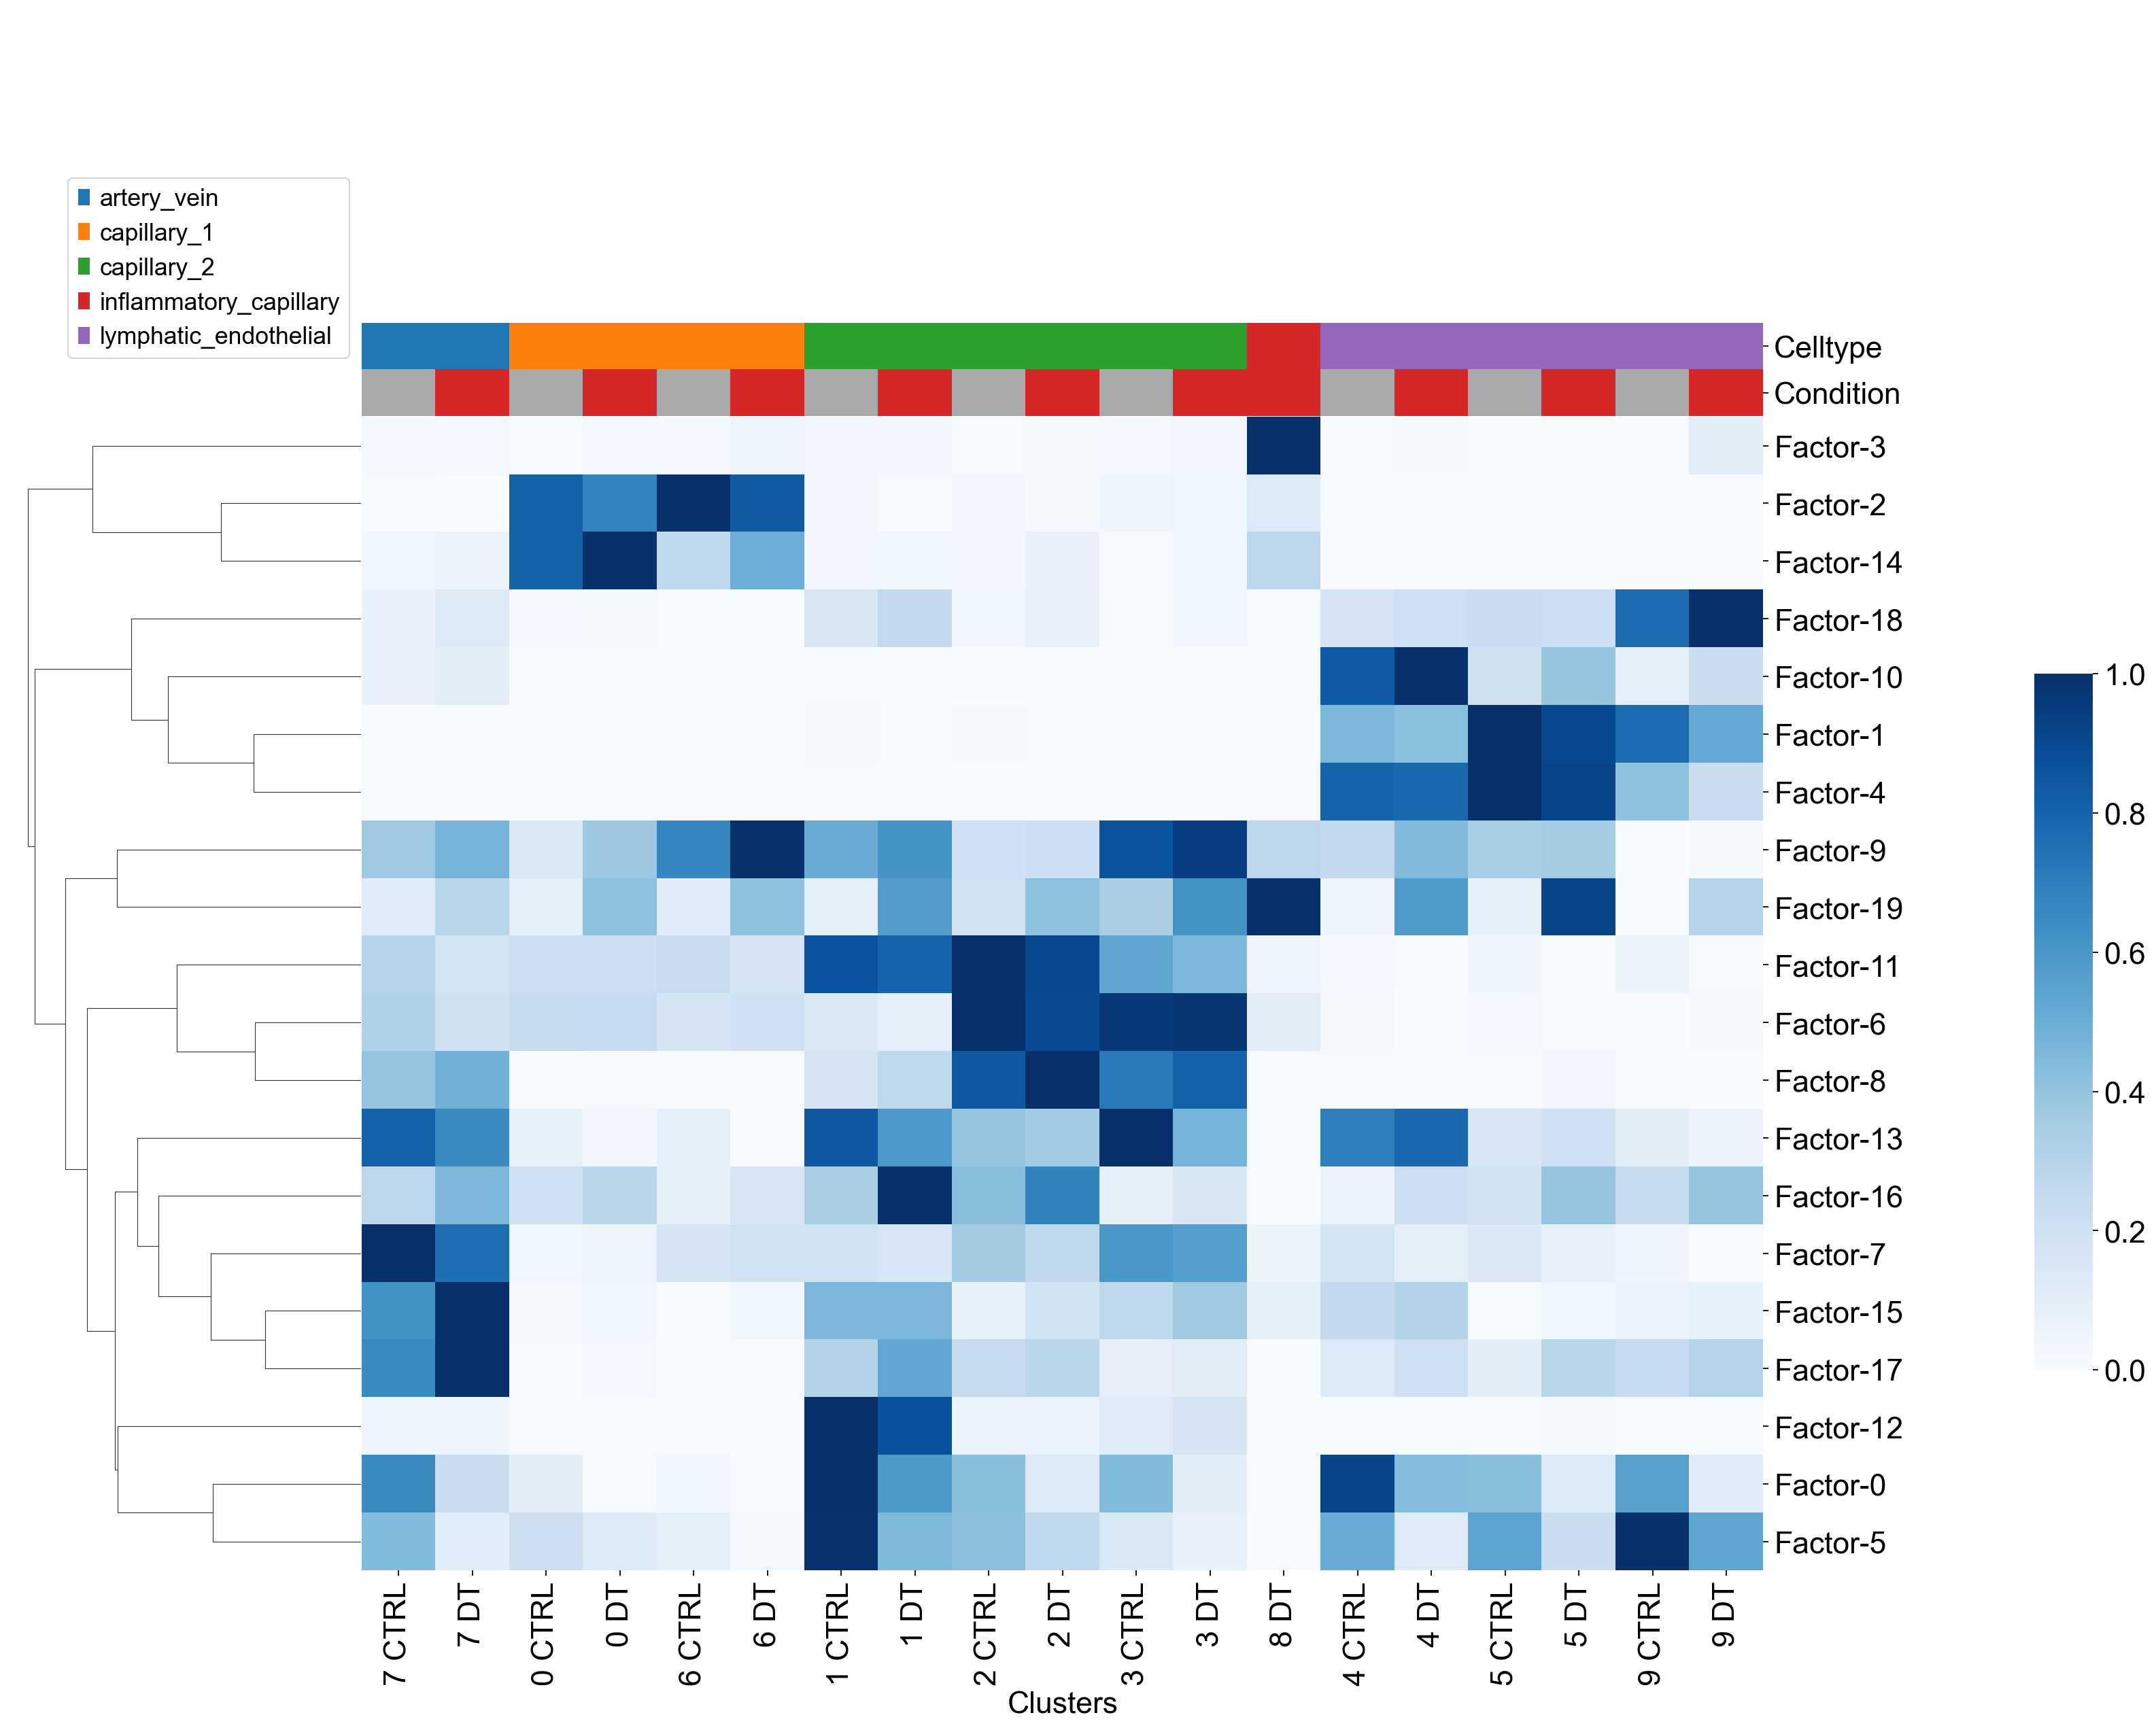

In [145]:
%matplotlib inline
sc.set_figure_params(scanpy=True, fontsize = 20)
g = sns.clustermap(endo_factor_mean_relabel.T, #loc[celltype_cond_order].T, 
               standard_scale=0, 
               row_colors=None, col_colors=col_colors,
               col_cluster=False, cbar_pos=(1.05, .2, .03, .4),
               cmap='Blues', figsize=(18,16))
g.ax_heatmap.set_xlabel('Clusters')
#plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=490, va = "top")

for label in color_val_ctype.keys():
    g.ax_col_dendrogram.bar(0, 0, color=color_val_ctype[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor = (0, 0.5), fontsize = 16)

# To save figure:
#g.savefig(outbase + 'factor_average_celltype_with_clusters_endo.png', dpi = 150, bbox_inches = 'tight')

# Factors robustness

## Correlations

In [15]:
#inbase = '/Users/rs3380/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/over_iterations/'
inbase = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/robustness_data/'
    
g_mean_coll = []
g_median_coll = []

c_mean_coll = []
c_median_coll = []

for nf in range(14, 28, 2):
    print(nf)
    cs_dict = {}
    gs_dict = {}
    
    for n_iter in range(20):
        cs_dict[str(n_iter)] = pd.read_csv(inbase + 'cs_' + str(nf) + 'f_iter_' + str(n_iter) + '_endo_v1.csv', 
                                                    index_col = 0)
        gs_dict[str(n_iter)] = pd.read_csv(inbase + 'gs_' + str(nf) + 'f_iter_' + str(n_iter) + '_endo_v1.csv', 
                                                    index_col = 0)
        
    c_mean = []
    c_median = []
    g_mean = []
    g_median = []
    
    for j in range(19):
        gs1 = gs_dict[str(j)]
        cs1 = cs_dict[str(j)]
        for k in range(j+1, 20):
            gs2 = gs_dict[str(k)]
            cs2 = cs_dict[str(k)]
            
            corr_res_gs = np.corrcoef(gs1.T, gs2.T)[0:gs1.shape[1], :][:, gs1.shape[1]:]
            corr_res_cs = np.corrcoef(cs1.T, cs2.T)[0:cs1.shape[1], :][:, cs1.shape[1]:]

            #g = sns.clustermap(corr_res, vmin = -1, vmax = 1, cmap = 'bwr', 
            #      figsize = (6, 6))
            #g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 10)
            #g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 10)
        
            cost_mat = 1 - corr_res_gs
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat)
            g_mean.append(np.mean((1-cost_mat)[row_ind, col_ind]))
            g_median.append(np.median((1-cost_mat)[row_ind, col_ind]))
            
            cost_mat_cs = 1 - corr_res_cs
            row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat_cs)
            c_mean.append(np.mean((1-cost_mat_cs)[row_ind, col_ind]))
            c_median.append(np.median((1-cost_mat_cs)[row_ind, col_ind]))
        
    g_mean_coll.append(g_mean)
    g_median_coll.append(g_median)
    c_mean_coll.append(c_mean)
    c_median_coll.append(c_median)
    

14
16
18
20
22
24
26


In [16]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

In [17]:
df_g_med = pd.DataFrame(g_median_coll, columns = range(190), index = [str(j) for j in range(14, 28, 2)])
df_c_med = pd.DataFrame(c_median_coll, columns = range(190), index = [str(j) for j in range(14, 28, 2)])

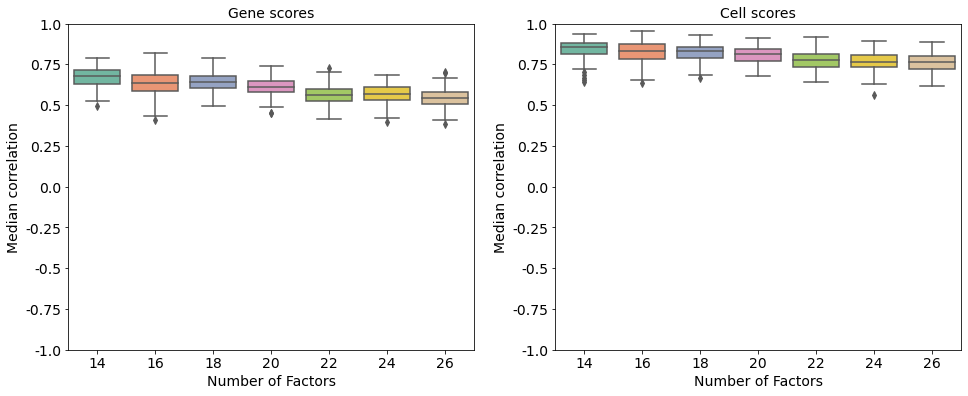

In [18]:
%matplotlib inline
fs = 14
fig = plt.figure(figsize = (8*2, 6*1))
ax = fig.add_subplot(1, 2, 1)
b = sns.boxplot(data=df_g_med.T, ax = ax, palette="Set2")
b.set_ylim([-1, 1])
ax.set_xlabel('Number of Factors', fontsize = fs)
ax.set_ylabel('Median correlation', fontsize = fs)
ax.set_title('Gene scores', fontsize = fs)
b.set_yticklabels(b.get_yticks(), size = fs)
b.set_xticklabels(range(14, 28, 2), size = fs)


ax = fig.add_subplot(1, 2, 2)
b = sns.boxplot(data=df_c_med.T, ax = ax, palette="Set2")
b.set_ylim([-1, 1])
ax.set_xlabel('Number of Factors', fontsize = fs)
ax.set_ylabel('Median correlation', fontsize = fs)
ax.set_title('Cell scores', fontsize = fs)
b.set_yticklabels(b.get_yticks(), size = fs)
b.set_xticklabels(range(14, 28, 2), size = fs)

df_g_med.to_csv('/Users/sharmar1/Dropbox/lung_tumor/new_folders/source_data/Figure_S5A_top_panel_exp2_endo_robustness_gene_scores.csv')
df_c_med.to_csv('/Users/sharmar1/Dropbox/lung_tumor/new_folders/source_data/Figure_S5A_top_panel_exp2_endo_robustness_cell_scores.csv')
#fig.savefig(outbase + 'robustness_data/robustness_over_random_iterations.png', dpi = 150, bbox_inches = 'tight')

## Robustness for select factors

In [7]:
gs_saved = pd.read_csv('/Users/sharmar1/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_schpf_20f_gene_scores.csv',
                              index_col=0)
cs_saved = pd.read_csv('/Users/sharmar1/Dropbox/lung_tumor/lineage_analysis_061019/endothelial_analysis/endo_data/endo_schpf_20f_cell_scores.csv',
                              index_col=0)

In [8]:
factors_of_interest = [3, 8, 9, 15, 17]
factors_of_interest_names = ['Factor 3: Activated VEC', 'Factor 8', 'Factor 9', 
                             'Factor 15: Inflammation and Hypoxia', 'Factor 17: EMT']

In [9]:
factors_gs = gs_saved[[str(j) for j in factors_of_interest]]
factors_cs = cs_saved[[str(j) for j in factors_of_interest]]

In [10]:
#inbase = '/Users/rs3380/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/over_iterations/'
inbase = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial/robustness_data/'
g_mean = []; c_mean = []
for nf in range(14, 28, 2):
    print(nf)
    g_mean_temp = np.zeros(shape = (20, len(factors_of_interest)))
    c_mean_temp = np.zeros(shape = (20, len(factors_of_interest)))
    
    for n_iter in range(20):
        cs_res = pd.read_csv(inbase + 'cs_' + str(nf) + 'f_iter_' + str(n_iter) + '_endo_v1.csv', index_col = 0)
        gs_res = pd.read_csv(inbase + 'gs_' + str(nf) + 'f_iter_' + str(n_iter) + '_endo_v1.csv', index_col = 0)
    
        cs_res = cs_res.loc[factors_cs.index]
        gs_res = gs_res.loc[factors_gs.index]
    
        corr_res_gs = np.corrcoef(factors_gs.T, gs_res.T)[0:factors_gs.shape[1], :][:, factors_gs.shape[1]:]
        #pd_gs = pd.DataFrame(corr_res_gs, index = factors_gs.columns, columns = gs_res.columns)
    
        corr_res_cs = np.corrcoef(factors_cs.T, cs_res.T)[0:factors_cs.shape[1], :][:, factors_cs.shape[1]:]
        #pd_cs = pd.DataFrame(corr_res_cs, index = factors_cs.columns, columns = cs_res.columns)
    
        cost_mat = 1 - corr_res_gs
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat)
        g_mean_temp[n_iter, :] = (1-cost_mat)[row_ind, col_ind]
            
        cost_mat_cs = 1 - corr_res_cs
        row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat_cs)
        c_mean_temp[n_iter, :] = (1-cost_mat_cs)[row_ind, col_ind]
    
    g_mean.append(g_mean_temp)
    c_mean.append(c_mean_temp)

14
16
18
20
22
24
26


In [11]:
import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')

In [12]:
out_dir2 = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/source_data/'

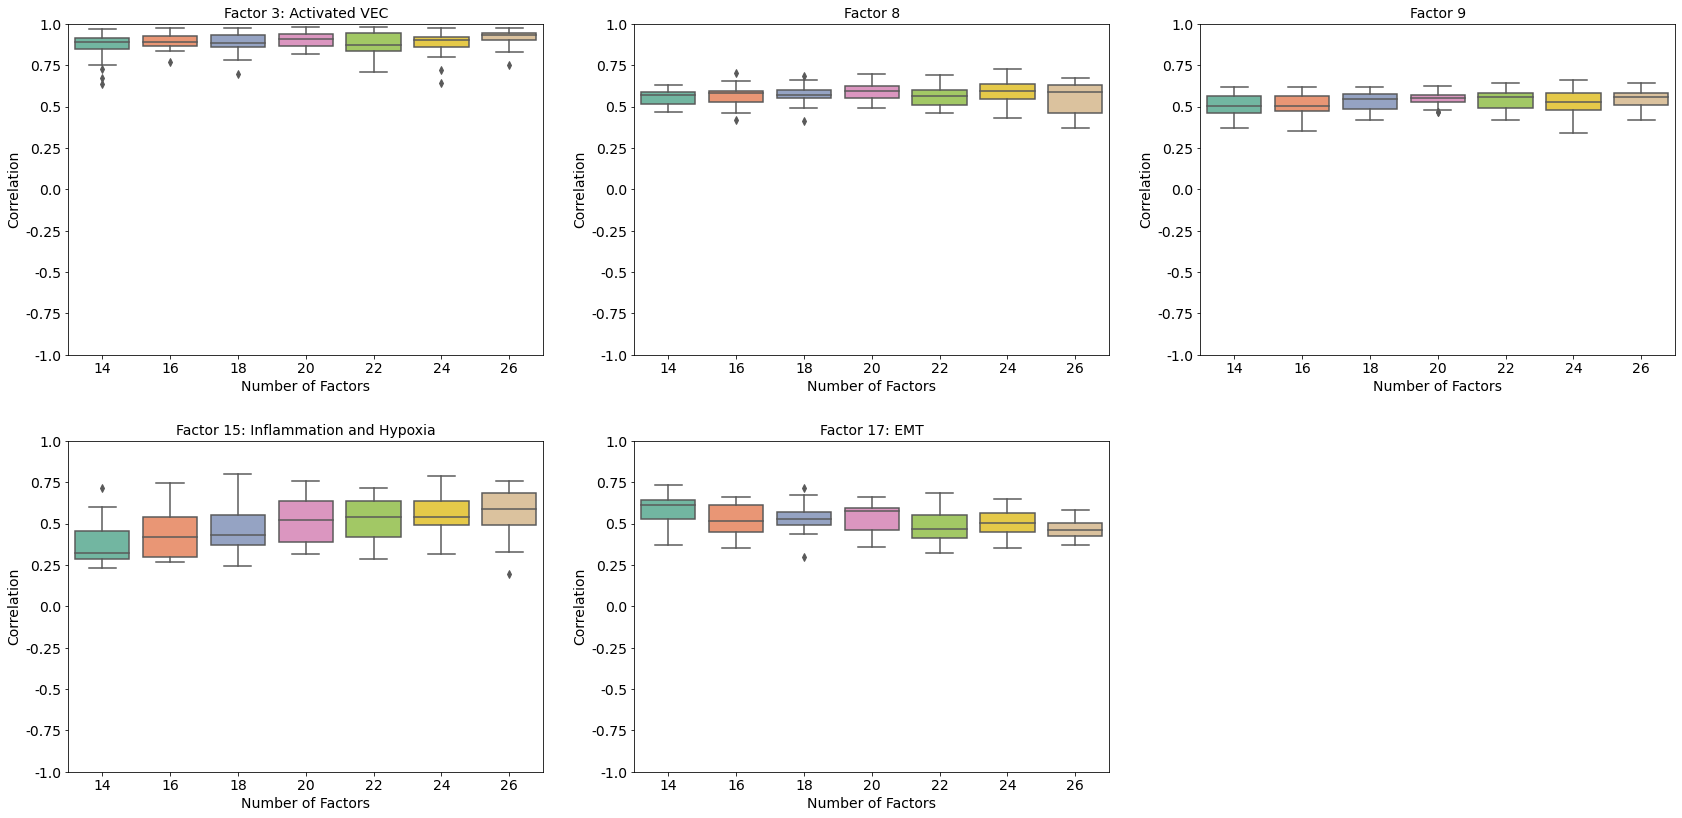

In [32]:
%matplotlib inline
fs = 14
fig = plt.figure(figsize = (8*3, 6*2))
for j in range(len(factors_of_interest)):
    ax = fig.add_subplot(2, 3, j+1)
    g_temp_list = [g_mean[ct][:, j] for ct in range(len(range(14, 28, 2)))]
    df_temp = pd.DataFrame(g_temp_list, columns = range(20), index = range(14, 28, 2))
    b = sns.boxplot(data=df_temp.T, ax = ax, palette="Set2")
    b.set_ylim([-1, 1])
    ax.set_xlabel('Number of Factors', fontsize = fs)
    ax.set_ylabel('Correlation', fontsize = fs)
    ax.set_title(factors_of_interest_names[j], fontsize = fs)
    b.set_yticklabels(b.get_yticks(), size = fs)
    b.set_xticklabels(range(14, 28, 2), size = fs)
    #df_temp.to_csv(out_dir2 + 'exp2_endo_robustness_gene_scores_factor_' + factors_of_interest_names[j] + '.csv')
fig.tight_layout(pad = 3)
fig.savefig(outbase + 'robustness_data/robustness_select_factors_v1_gene_scores_new.png', dpi = 150, bbox_inches = 'tight')

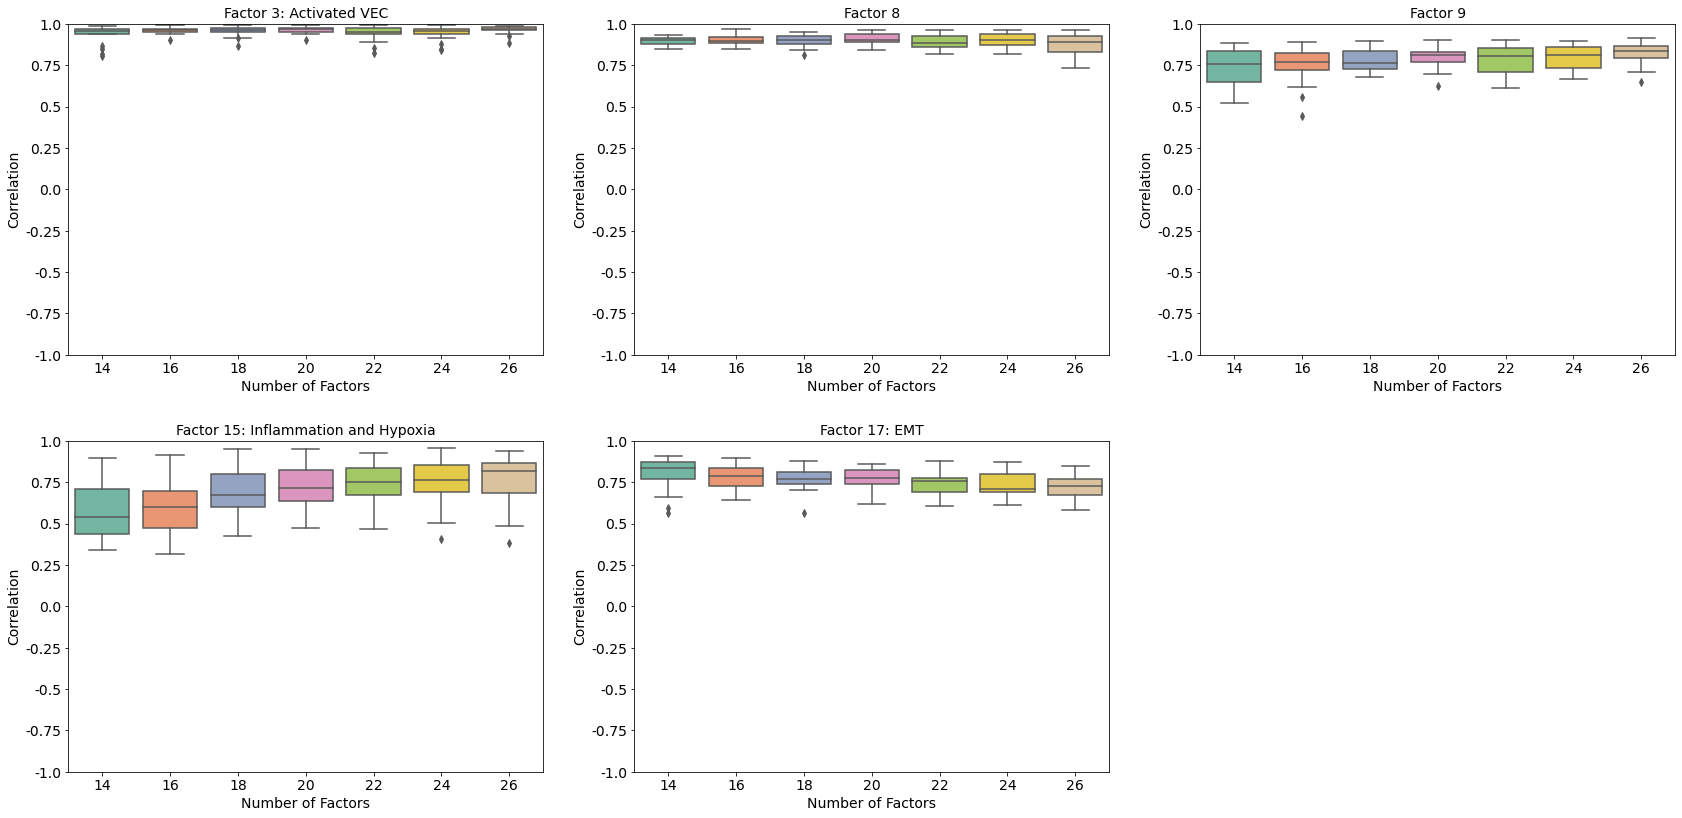

In [14]:
fig = plt.figure(figsize = (8*3, 6*2))
for j in range(len(factors_of_interest)):
    ax = fig.add_subplot(2, 3, j+1)
    g_temp_list = [c_mean[ct][:, j] for ct in range(len(range(14, 28, 2)))]
    df_temp = pd.DataFrame(g_temp_list, columns = range(20), index = range(14, 28, 2))
    b = sns.boxplot(data=df_temp.T, ax = ax, palette="Set2")
    b.set_ylim([-1, 1])
    ax.set_xlabel('Number of Factors', fontsize = fs)
    ax.set_ylabel('Correlation', fontsize = fs)
    ax.set_title(factors_of_interest_names[j], fontsize = fs)
    b.set_yticklabels(b.get_yticks(), size = fs)
    b.set_xticklabels(range(14, 28, 2), size = fs)
    df_temp.to_csv(out_dir2 + 'exp2_endo_robustness_cell_scores_factor_' + factors_of_interest_names[j] + '.csv')
fig.tight_layout(pad = 3)
#fig.savefig(outbase + 'robustness_data/robustness_select_factors_v1_cell_scores_new.png', dpi = 150, 
#            bbox_inches = 'tight')

# Milo

In [10]:
import rpy2
import anndata2ri
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
os.environ['R_USER'] = '/Library/Frameworks/R.framework/Resources'

# anndata2ri interconverts AnnData and Single Cell Experiment objects
anndata2ri.activate()
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [11]:
adata_endo

AnnData object with n_obs × n_vars = 2815 × 12131
    obs: 'Clusters', 'Celltype', 'SampleID', 'name', 'background', 'condition', 'replicate', 'experiment', 'ncells', 'libsize', 'mito_fraction', 'ribo_fraction', 'mhc_fraction', 'actin_fraction', 'cytoskeleton_fraction', 'malat1_fraction', 'scrublet_predict', 'scrublet_score', 'lowlibsize', 'Endo_prelim_clusters', 'Clusters_endo', 'Celltype_endo'
    obsm: 'X_pca', 'X_tsne', 'imputed_data'
    layers: 'norm_count', 'norm_log'

## Object for milo

In [12]:
adata_endo_milo = sc.AnnData(adata_endo.layers['norm_log'].copy(), 
                                obs = adata_endo.obs, 
                                var = adata_endo.var)
adata_endo_milo.obsm['X_pca'] = adata_endo.obsm['X_pca']
adata_endo_milo.obsm['X_tsne'] = adata_endo.obsm['X_tsne']

<ipython-input-12-f9e2588eab2f>:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_endo_milo = sc.AnnData(adata_endo.layers['norm_log'].copy(),


## Set up in R

In [13]:
%%R
library(miloR)
library(igraph)

R[write to console]: Loading required package: edgeR

R[write to console]: Loading required package: limma

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following object is masked from ‘package:miloR’:

    graph


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




In [14]:
%%R -i adata_endo_milo
adata_endo_milo

/Users/sharmar1/opt/anaconda3/envs/scri_env/lib/python3.8/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


class: SingleCellExperiment 
dim: 12131 2815 
metadata(0):
assays(1): X
rownames(12131): GNAI3 CDC45 ... RP23-381H23.2 GM10600
rowData names(0):
colnames(2815): 120703409145716001 120703409646299001 ...
  241114589027246011 241114589063987011
colData names(22): Clusters Celltype ... Clusters_endo Celltype_endo
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):


In [15]:
%%R 
endo_milo <- Milo(adata_endo_milo)
endo_milo

class: Milo 
dim: 12131 2815 
metadata(0):
assays(1): X
rownames(12131): GNAI3 CDC45 ... RP23-381H23.2 GM10600
rowData names(0):
colnames(2815): 120703409145716001 120703409646299001 ...
  241114589027246011 241114589063987011
colData names(22): Clusters Celltype ... Clusters_endo Celltype_endo
reducedDimNames(2): PCA TSNE
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [16]:
%%R 
endo_milo <- buildGraph(endo_milo, k=30, d=50, reduced.dim = "PCA")

R[write to console]: Constructing kNN graph with k:30



## Design Matrix

In [21]:
design_df = adata_endo.obs[["condition", "SampleID"]].copy()
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['SampleID']
design_df

condition           SampleID
SampleID                                      
2_DT_1_CD45plus          DT    2_DT_1_CD45plus
2_DT_2_CD45minus         DT   2_DT_2_CD45minus
2_DT_2_CD45plus          DT    2_DT_2_CD45plus
2_DT_3_CD45_minus        DT  2_DT_3_CD45_minus
2_DT_3_CD45plus          DT    2_DT_3_CD45plus
2_ctl_1_CD45minus      CTRL  2_ctl_1_CD45minus
2_ctl_1_CD45plus       CTRL   2_ctl_1_CD45plus
2_ctl_2_CD45minus      CTRL  2_ctl_2_CD45minus
ctl_3_CD45_minus       CTRL   ctl_3_CD45_minus

## Differential analysis 

In [22]:
%%R -i design_df -o DA_results_endo
## Define neighbourhoods
endo_milo <- makeNhoods(endo_milo, prop = 0.1, k = 30, d=50, refined = TRUE, reduced_dims = "PCA")

## Count cells in neighbourhoods
endo_milo <- countCells(endo_milo, meta.data = data.frame(colData(endo_milo)), sample="SampleID")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
endo_milo <- calcNhoodDistance(endo_milo, d=50, reduced.dim = "PCA")

## Test for differential abundance
DA_results_endo <- testNhoods(endo_milo, design = ~condition, design.df = design_df)

R[write to console]: Checking valid object

R[write to console]: Running refined sampling with reduced_dim

R[write to console]: Checking meta.data validity

R[write to console]: Counting cells in neighbourhoods

R[write to console]: Using TMM normalisation

R[write to console]: Performing spatial FDR correction withk-distance weighting



In [23]:
DA_results_endo.head()

logFC     logCPM         F    PValue       FDR  Nhood  SpatialFDR
1 -1.571567  14.617202  2.859252  0.091086  0.313180    1.0    0.308245
2  1.010590  13.944836  1.078911  0.299132  0.568049    2.0    0.556970
3 -1.562745  14.383951  2.794816  0.094807  0.313180    3.0    0.308245
4 -1.888226  14.809839  4.252101  0.039398  0.247127    4.0    0.244500
5 -1.569763  14.311296  3.035800  0.081680  0.313180    5.0    0.308245

Text(0, 0.5, '- log10(Spatial FDR)')

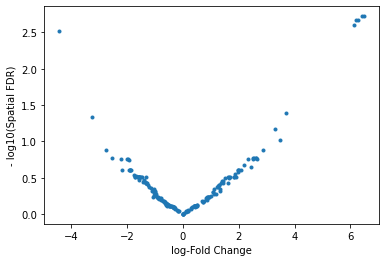

In [24]:
plt.plot(DA_results_endo.logFC, -np.log10(DA_results_endo.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

Text(0, 0.5, '- log10(Spatial FDR)')

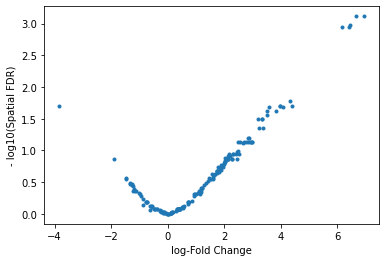

In [59]:
plt.plot(DA_results_endo.logFC, -np.log10(DA_results_endo.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

## Visualize in R

In [25]:
%%R
endo_milo <- buildNhoodGraph(endo_milo)

In [26]:
%%R 
head(DA_results_endo)

      logFC   logCPM        F     PValue       FDR Nhood SpatialFDR
1 -1.571567 14.61720 2.859252 0.09108650 0.3131800     1  0.3082448
2  1.010590 13.94484 1.078911 0.29913221 0.5680490     2  0.5569704
3 -1.562745 14.38395 2.794816 0.09480738 0.3131800     3  0.3082448
4 -1.888226 14.80984 4.252101 0.03939774 0.2471268     4  0.2445000
5 -1.569763 14.31130 3.035800 0.08167999 0.3131800     5  0.3082448
6 -1.245143 14.59575 1.914469 0.16670237 0.4017955     6  0.3935449


In [27]:
#%%R -w 800 -h 600
#alpha_val = 1
#library(ggplot2)
#p1 <- plotNhoodGraphDA(endo_milo, DA_results_endo, alpha=alpha_val, 
#                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
#p1 <- p1 + scale_fill_gradient2(low = '#2166AC', mid = 'white', high = '#B2182B')
#p1

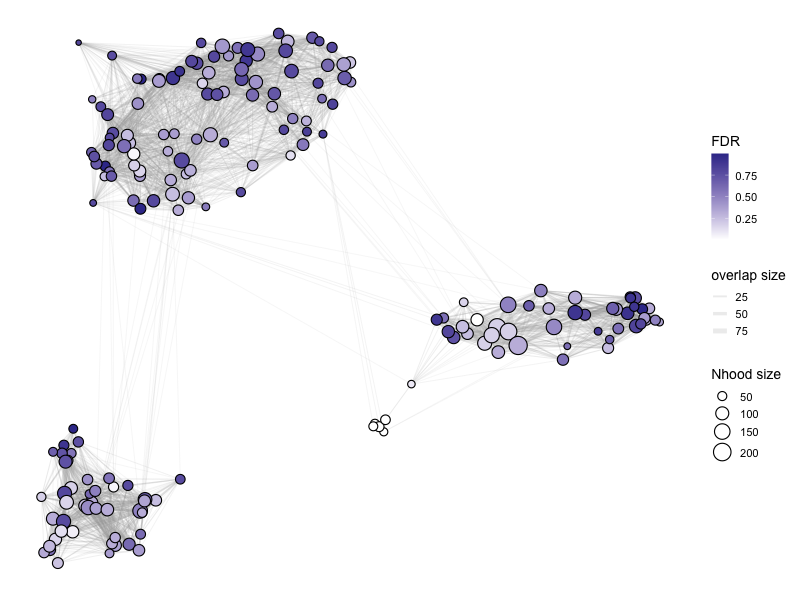

In [28]:
%%R -w 800 -h 600
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(endo_milo, DA_results_endo, res_column = 'FDR', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
#p1 <- p1 + scale_fill_manual()
p1

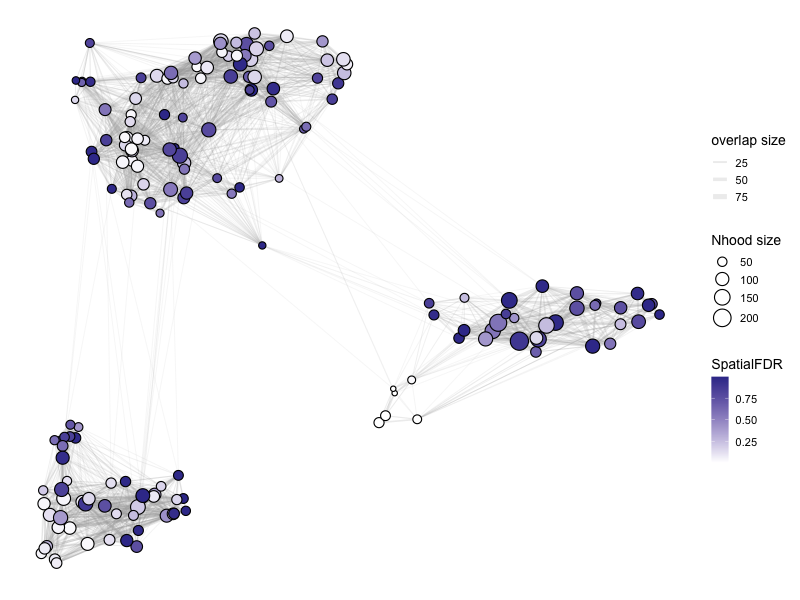

In [128]:
%%R -w 800 -h 600
alpha_val = 1
library(ggplot2)
p1 <- plotNhoodGraphDA(endo_milo, DA_results_endo, res_column = 'SpatialFDR', alpha=alpha_val, 
                 layout="TSNE", size_range = c(2, 8), node_stroke =0.8)
#p1 <- p1 + scale_fill_manual()
p1

In [90]:
outbase

'/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial_milo_revision/'

In [91]:
%%R -w 600 -h 450
library(ggplot2)
alpha_val = 1
outbase = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial_milo_revision/'
for (j in c('SpatialFDR', 'FDR', 'PValue', 'logFC')){
    p1 <- plotNhoodGraphDA(endo_milo, DA_results_endo, res_column = j, alpha=alpha_val, layout="TSNE", 
                           size_range = c(2, 8), node_stroke =.8)
    p1    
    ggsave(paste0(outbase, 'milor_R_endo_', j, '_feb22.pdf'), p1, dpi = 200)
}

Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image
Saving 8.33 x 6.25 in image


In [92]:
outbase

'/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial_milo_revision/'

## Add celltype info

In [93]:
%%R 
DA_results_endo <- annotateNhoods(endo_milo, DA_results_endo, coldata_col = "Celltype_endo")
head(DA_results_endo)

        logFC   logCPM            F       PValue        FDR Nhood SpatialFDR
1 0.009288576 14.14002 7.159054e-05 0.9932504778 0.99850883     1 0.99850883
2 4.405159823 13.48335 1.109751e+01 0.0008905068 0.01785335     2 0.02011793
3 2.414056065 14.08257 5.117045e+00 0.0238685644 0.11160167     3 0.11220686
4 0.108080335 13.91461 1.238825e-02 0.9113949011 0.95293399     4 0.95073092
5 0.403909316 14.72372 2.032078e-01 0.6522246938 0.84383511     5 0.83937799
6 0.156272197 14.32245 2.723408e-02 0.8689498684 0.95042397     6 0.94819177
           Celltype_endo Celltype_endo_fraction
1            capillary_2              0.9545455
2 inflammatory_capillary              0.6388889
3            capillary_2              0.9736842
4            capillary_2              1.0000000
5            capillary_2              0.9428571
6            capillary_1              0.9888889


Cell type fraction distribution

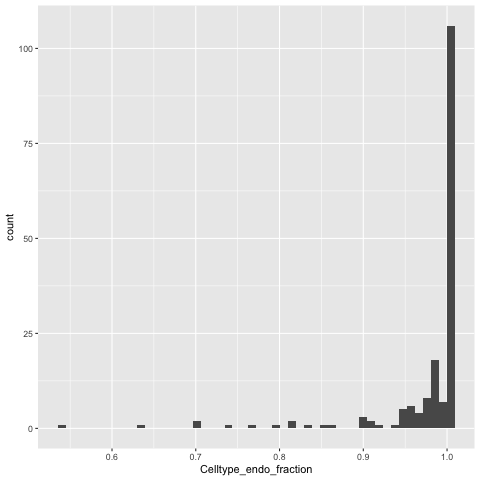

In [94]:
%%R
library(ggplot2)
ggplot(DA_results_endo, aes(Celltype_endo_fraction)) + geom_histogram(bins=50)


In [95]:
%%R -o DA_results_endo
DA_results_endo$Endothelial_Celltypes <- ifelse(DA_results_endo$Celltype_endo_fraction < 0.8, "Mixed", DA_results_endo$Celltype_endo)
head(DA_results_endo)

        logFC   logCPM            F       PValue        FDR Nhood SpatialFDR
1 0.009288576 14.14002 7.159054e-05 0.9932504778 0.99850883     1 0.99850883
2 4.405159823 13.48335 1.109751e+01 0.0008905068 0.01785335     2 0.02011793
3 2.414056065 14.08257 5.117045e+00 0.0238685644 0.11160167     3 0.11220686
4 0.108080335 13.91461 1.238825e-02 0.9113949011 0.95293399     4 0.95073092
5 0.403909316 14.72372 2.032078e-01 0.6522246938 0.84383511     5 0.83937799
6 0.156272197 14.32245 2.723408e-02 0.8689498684 0.95042397     6 0.94819177
           Celltype_endo Celltype_endo_fraction Endothelial_Celltypes
1            capillary_2              0.9545455           capillary_2
2 inflammatory_capillary              0.6388889                 Mixed
3            capillary_2              0.9736842           capillary_2
4            capillary_2              1.0000000           capillary_2
5            capillary_2              0.9428571           capillary_2
6            capillary_1              0.9

R[write to console]: Converting group.by to factor...



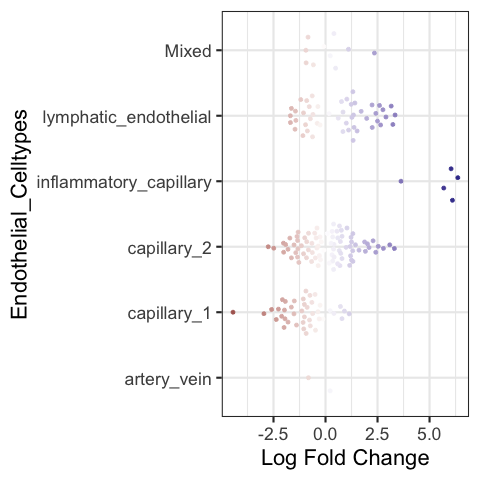

In [34]:
%%R
plotDAbeeswarm(DA_results_endo, group.by = "Endothelial_Celltypes", alpha = 1)

In [35]:
%%R
type(DA_results_endo$Endothelial_Celltypes)

[1] "character"


In [36]:
%%R -w 600 -h 600
library(ggplot2)
library(ggbeeswarm)
library(scales)

p1 <- plotDAbeeswarm(DA_results_endo, group.by = "Endothelial_Celltypes", alpha = alpha_val) 
#p1 <- p1 + geom_quasirandom(shape = 1, colour="black", size = 3) 
#p1 <- p1 + geom_quasirandom(size = 3)


p1 <- p1 + geom_quasirandom(size = 3) 
p1 <- p1 + scale_color_gradient2(low = "navyblue", mid = "gray74", high = "darkred", guide = "colourbar")


outbase = '/Users/sharmar1/Dropbox/lung_tumor/new_folders/output/exp2/endothelial_milo_revision/'
ggsave(paste0(outbase, 'milor_R_endo_swarmplot_v2_july13.pdf'), p1, dpi = 200)

R[write to console]: Converting group.by to factor...

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

R[write to console]: Saving 8.33 x 8.33 in image



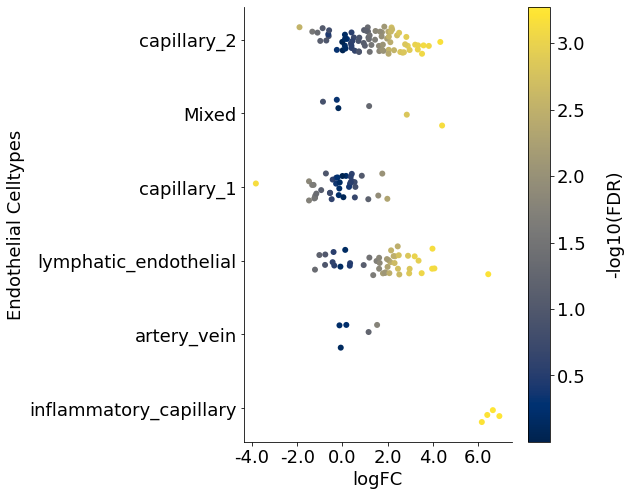

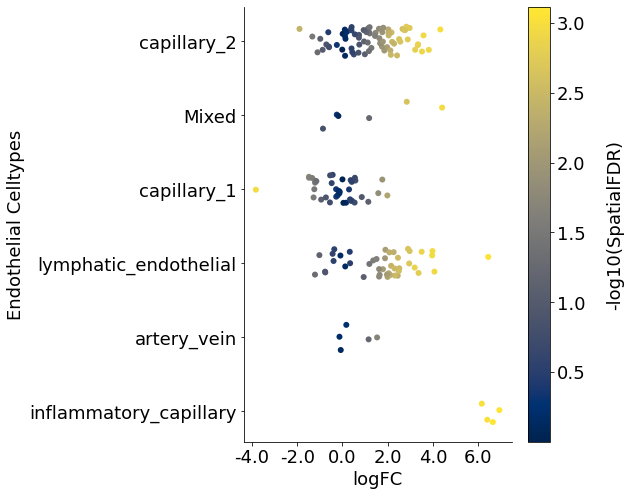

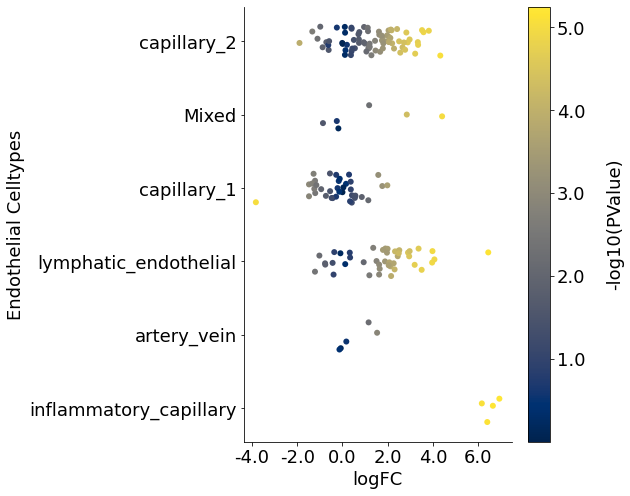

In [96]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

for j, item in enumerate(['FDR', 'SpatialFDR', 'PValue']):
    fig = plt.figure(figsize = (6, 8))
    DA_results_endo['log_' + item] = -np.log10(DA_results_endo[item])
    ax = fig.add_subplot(1, 1, 1)
    plot = sns.stripplot(x='logFC', y='Endothelial_Celltypes', hue='log_' + item, data=DA_results_endo, size = 6, 
              palette='cividis', 
              jitter=0.2, edgecolor='none', ax = ax)
    plot.get_legend().set_visible(False)
    ax.set_xticklabels(ax.get_xticks(), fontsize = 18)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 18)
    ax.set_ylabel('Endothelial Celltypes', fontsize = 18)
    ax.set_xlabel('logFC', fontsize = 18)
    sns.despine()


    # Drawing the side color bar
    normalize = mcolors.Normalize(vmin=DA_results_endo['log_' + item].min(), 
                              vmax=DA_results_endo['log_' + item].max())
    colormap = cm.cividis

    for n in DA_results_endo['log_' + item]:
        plt.plot(color=colormap(normalize(n)))

    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(DA_results_endo['log_' + item])
    cbar = fig.colorbar(scalarmappaple)
    cbar.ax.set_yticklabels(cbar.ax.get_yticks(), fontsize = 18)
    cbar.ax.set_ylabel('-log10(' + item + ')',  labelpad = 20, rotation=90, fontsize = 18)
    ax.grid(False)
    fig.savefig(outbase + 'milor_endothelial_swarmplot_new_colored_by_log_' + item + '_feb22.pdf', dpi = 300, 
                bbox_inches = 'tight')

In [98]:
# For source data
DA_results_endo.to_csv('/Users/sharmar1/Dropbox/lung_tumor/new_folders/source_data/Figure_2H.csv')